# Generate tables for analysis

In [1]:
%load_ext autoreload
%autoreload 2

from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import utils

pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
pd.options.display.float_format = '{:,.5f}'.format
sns.set_theme(style="darkgrid")

# --- Constants ---
LARGE_CORP_MIN_SALES = 50
MED_CORP_MIN_SALES = 10
# -----------------

def format_thousands(value, tick_number):
    if value >= 1000:
        value = int(round(value / 1000, 0))
        return f"{value}K"
    else:
        return int(value)
    
def format_hundreds(value, tick_number):
    if value >= 1000:
        value = float(round(value / 1000, 1))
        return f"{value}K"
    else:
        return int(value)

def format_percent(value, tick_number):
    return f"{int(value)}%"

def format_millions(value, tick_number):
    return f"${int(value/1000000)}M"

# classify grantee/grantor by corp size
def classify_corp(x):
    if x > LARGE_CORP_MIN_SALES:
        return 3
    elif x > MED_CORP_MIN_SALES:
        return 2
    else:
        return 1
    
DATA_PATH = 'output/'

digest = pd.read_parquet(DATA_PATH + 'digest_full_final.parquet')
sales = pd.read_parquet(DATA_PATH + 'sales_full_final.parquet')

parcel_geo = pd.read_csv(DATA_PATH + 'parcels_geo.csv')
nsa_geo = gpd.read_file('data/atl_nsa.geojson')
nsa_stats = pd.read_csv('data/atl_nsa_stats.csv')

print(f"Len digest: {len(digest)}")
print(f"Len sales: {len(sales)}")

Len digest: 2739296
Len sales: 150284


## Merge geodata with parcels and sales

In [3]:
# Convert "Saledt" to "Sale Year"
sales["Sale Year"] = sales["Saledt"].apply(lambda x: x.split("-")[-1]).astype(int)

# Geocode
digest = digest.merge(parcel_geo, on='PARID', how='left')
sales = sales.merge(parcel_geo, on='PARID', how='left')

# Create valid and invalid subsets for valid and invalid sales
valid_sales = sales[sales["Saleval"] == "0"]
valid_atl = valid_sales[valid_sales["neighborhood"].notna()]

invalid_sales = sales[sales["Saleval"] != "0"]
invalid_atl = invalid_sales[invalid_sales["neighborhood"].notna()]

# Create ATL subsets for total sales and digest
digest_atl = digest[digest["neighborhood"].notna()]
sales_atl = sales[sales["neighborhood"].notna()]

print(f"Parcel records in ATL: {len(digest_atl)}")
print(f"Sale records in ATL: {len(sales_atl)}")
print(f"Len invalid_sales: {len(invalid_sales)}")
print(f"Len invalid_atl: {len(invalid_atl)}")
print(f"Len valid_sales: {len(valid_sales)}")
print(f"Len valid_atl: {len(valid_atl)}")

Parcel records in ATL: 985666
Sale records in ATL: 55454
Len invalid_sales: 37595
Len invalid_atl: 17465
Len valid_sales: 112689
Len valid_atl: 37989


## Total SFH Sales in Fulton County and Atlanta (figure no longer used)

In [4]:
def calculate_counts(df, label, group_col='Sale Year'):
    return df.groupby(group_col)['PARID'].count().reset_index(name=label)

dfs = []
df_label = {
    'Total': sales,
    'Total Fulton Excl Atl': sales[sales["neighborhood"].isna()],
    'Valid Fulton Excl Atl': valid_sales[valid_sales["neighborhood"].isna()],
    'Invalid Fulton Excl Atl': invalid_sales[invalid_sales["neighborhood"].isna()],
    'Total Atlanta': sales_atl,
    'Valid Atlanta': valid_atl,
    'Invalid Atlanta': invalid_atl
}
for label, df in df_label.items():
    dfs.append(calculate_counts(df, label))

total_sales = reduce(lambda left, right: pd.merge(left, right, on='Sale Year'), dfs)

pct_cols = [
    "Valid Fulton Excl Atl",
    "Invalid Fulton Excl Atl",
    "Valid Atlanta",
    "Invalid Atlanta"
]

pcts = total_sales[pct_cols].divide(total_sales["Total"], axis=0).add_suffix(' %')

total_sales = pd.concat([total_sales, pcts], axis=1)
total_sales

Sale Year  Total  Total Fulton Excl Atl  Valid Fulton Excl Atl  \
0        2010   7126                   4380                   3408   
1        2011   6801                   4140                   2713   
2        2012   9604                   6169                   4837   
3        2013  10503                   6626                   6531   
4        2014  10399                   6591                   6449   
5        2015  12998                   8347                   2393   
6        2016  12485                   8055                   7660   
7        2017  15748                   9790                   7532   
8        2018  16250                  10136                   7866   
9        2019  15758                  10144                   8361   
10       2020  15456                   9844                   8434   
11       2021  17156                  10608                   8516   

    Invalid Fulton Excl Atl  Total Atlanta  Valid Atlanta  Invalid Atlanta  \
0                       972           2746           1932              814   
1                      1427           2661           1945              716   
2                      1332           3435           2580              855   
3                        95           3877           3788               89   
4                       142           3808           3608              200   
5                      5954           4651           1183             3468   
6                       395           4430           3825              605   
7                      2258           5958           3053             2905   
8                      2270           6114           3343             2771   
9                      1783           5614           3894             1720   
10                     1410           5612           4204             1408   
11                     2092           6548           4634             1914   

    Valid Fulton Excl Atl %  Invalid Fulton Excl Atl %  Valid Atlanta %  \
0                   0.47825                    0.13640          0.27112   
1                   0.39891                    0.20982          0.28599   
2                   0.50364                    0.13869          0.26864   
3                   0.62182                    0.00905          0.36066   
4                   0.62016                    0.01366          0.34696   
5                   0.18411                    0.45807          0.09101   
6                   0.61354                    0.03164          0.30637   
7                   0.47828                    0.14338          0.19387   
8                   0.48406                    0.13969          0.20572   
9                   0.53059                    0.11315          0.24711   
10                  0.54568                    0.09123          0.27200   
11                  0.49639                    0.12194          0.27011   

    Invalid Atlanta %  
0             0.11423  
1             0.10528  
2             0.08903  
3             0.00847  
4             0.01923  
5             0.26681  
6             0.04846  
7             0.18447  
8             0.17052  
9             0.10915  
10            0.09110  
11            0.11156

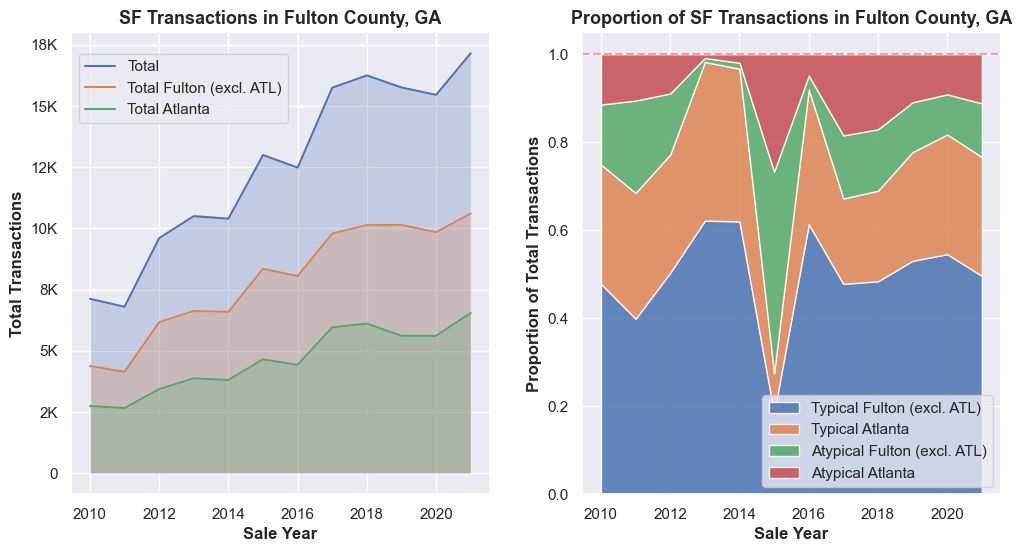

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'wspace': .22})

utils.area_plot(
    total_sales,
    "Sale Year",
    ["Total", "Total Fulton Excl Atl", "Total Atlanta"],
    ["Total", "Total Fulton (excl. ATL)", "Total Atlanta"],
    "Sale Year",
    "Total Transactions",
    title="SF Transactions in Fulton County, GA",
    ax=ax[0],
    format_func=format_thousands,
    format_tuple=(0, 1),
    legend={"loc": "upper left", "bbox_to_anchor": (0, 0.97)}
)

utils.stacked_plot(
    total_sales,
    "Sale Year",
    ["Valid Fulton Excl Atl %", "Valid Atlanta %", "Invalid Fulton Excl Atl %", "Invalid Atlanta %"],
    ["Typical Fulton (excl. ATL)", "Typical Atlanta", "Atypical Fulton (excl. ATL)", "Atypical Atlanta"],
    "Sale Year",
    y_label="Proportion of Total Transactions",
    title="Proportion of SF Transactions in Fulton County, GA",
    ax=ax[1],
    legend={"loc": "lower right"},
    opacity=.85
)

ax[1].axhline(y=1, color='red', linestyle='--', alpha=.35)

## Total Sales by Corporates and Table of Invalid Sales (figure no longer used)

In [6]:
# want total trans in Atlanta; total and invalid broken down by corp purchases and sales
dfs = []
df_label = {
    'Total Corp Trans Atl': sales_atl[(sales_atl['GRANTEE_corp_flag'] == 1) | (sales_atl['GRANTOR_corp_flag'] == 1)],
    'Total Corp Purchases Atl': sales_atl[sales_atl['GRANTEE_corp_flag'] == 1],
    'Total Corp Sales Atl': sales_atl[sales_atl['GRANTOR_corp_flag'] == 1],
    'Invalid Corp Purchases Atl': invalid_atl[invalid_atl['GRANTEE_corp_flag'] == 1],
    'Invalid Corp Sales Atl': invalid_atl[invalid_atl['GRANTOR_corp_flag'] == 1],
    'Valid Corp Purchases Atl': valid_atl[valid_atl['GRANTEE_corp_flag'] == 1],
    'Valid Corp Sales Atl': valid_atl[valid_atl['GRANTOR_corp_flag'] == 1]
}

for label, df in df_label.items():
    dfs.append(calculate_counts(df, label))

atlanta_breakdown = reduce(lambda left, right: pd.merge(left, right, on='Sale Year'), dfs)
total_sales = pd.merge(total_sales, atlanta_breakdown, on='Sale Year')
total_sales["Corp Trans Sum Atl"] = total_sales["Total Corp Purchases Atl"] + total_sales["Total Corp Sales Atl"]

pct_cols = [label for label in df_label.keys() if label != "Total Corp Trans Atl"]
pcts = total_sales[pct_cols].divide(total_sales["Corp Trans Sum Atl"], axis=0).add_suffix(' %')

pcts_of_corp_trans = total_sales[pct_cols].divide(total_sales["Corp Trans Sum Atl"], axis=0).add_suffix(' % Corp Trans')

total_sales = pd.concat([total_sales, pcts, pcts_of_corp_trans], axis=1)
total_sales

Sale Year  Total  Total Fulton Excl Atl  Valid Fulton Excl Atl  \
0        2010   7126                   4380                   3408   
1        2011   6801                   4140                   2713   
2        2012   9604                   6169                   4837   
3        2013  10503                   6626                   6531   
4        2014  10399                   6591                   6449   
5        2015  12998                   8347                   2393   
6        2016  12485                   8055                   7660   
7        2017  15748                   9790                   7532   
8        2018  16250                  10136                   7866   
9        2019  15758                  10144                   8361   
10       2020  15456                   9844                   8434   
11       2021  17156                  10608                   8516   

    Invalid Fulton Excl Atl  Total Atlanta  Valid Atlanta  Invalid Atlanta  \
0                       972           2746           1932              814   
1                      1427           2661           1945              716   
2                      1332           3435           2580              855   
3                        95           3877           3788               89   
4                       142           3808           3608              200   
5                      5954           4651           1183             3468   
6                       395           4430           3825              605   
7                      2258           5958           3053             2905   
8                      2270           6114           3343             2771   
9                      1783           5614           3894             1720   
10                     1410           5612           4204             1408   
11                     2092           6548           4634             1914   

    Valid Fulton Excl Atl %  Invalid Fulton Excl Atl %  Valid Atlanta %  \
0                   0.47825                    0.13640          0.27112   
1                   0.39891                    0.20982          0.28599   
2                   0.50364                    0.13869          0.26864   
3                   0.62182                    0.00905          0.36066   
4                   0.62016                    0.01366          0.34696   
5                   0.18411                    0.45807          0.09101   
6                   0.61354                    0.03164          0.30637   
7                   0.47828                    0.14338          0.19387   
8                   0.48406                    0.13969          0.20572   
9                   0.53059                    0.11315          0.24711   
10                  0.54568                    0.09123          0.27200   
11                  0.49639                    0.12194          0.27011   

    Invalid Atlanta %  Total Corp Trans Atl  Total Corp Purchases Atl  \
0             0.11423                  1254                       660   
1             0.10528                  1185                       629   
2             0.08903                  1594                       978   
3             0.00847                  1729                      1123   
4             0.01923                  1632                       957   
5             0.26681                  2105                      1193   
6             0.04846                  1999                      1031   
7             0.18447                  3338                      1962   
8             0.17052                  3609                      2138   
9             0.10915                  2965                      1377   
10            0.09110                  2645                      1022   
11            0.11156                  3055                      1593   

    Total Corp Sales Atl  Invalid Corp Purchases Atl  Invalid Corp Sales Atl  \
0                    941                         372                    

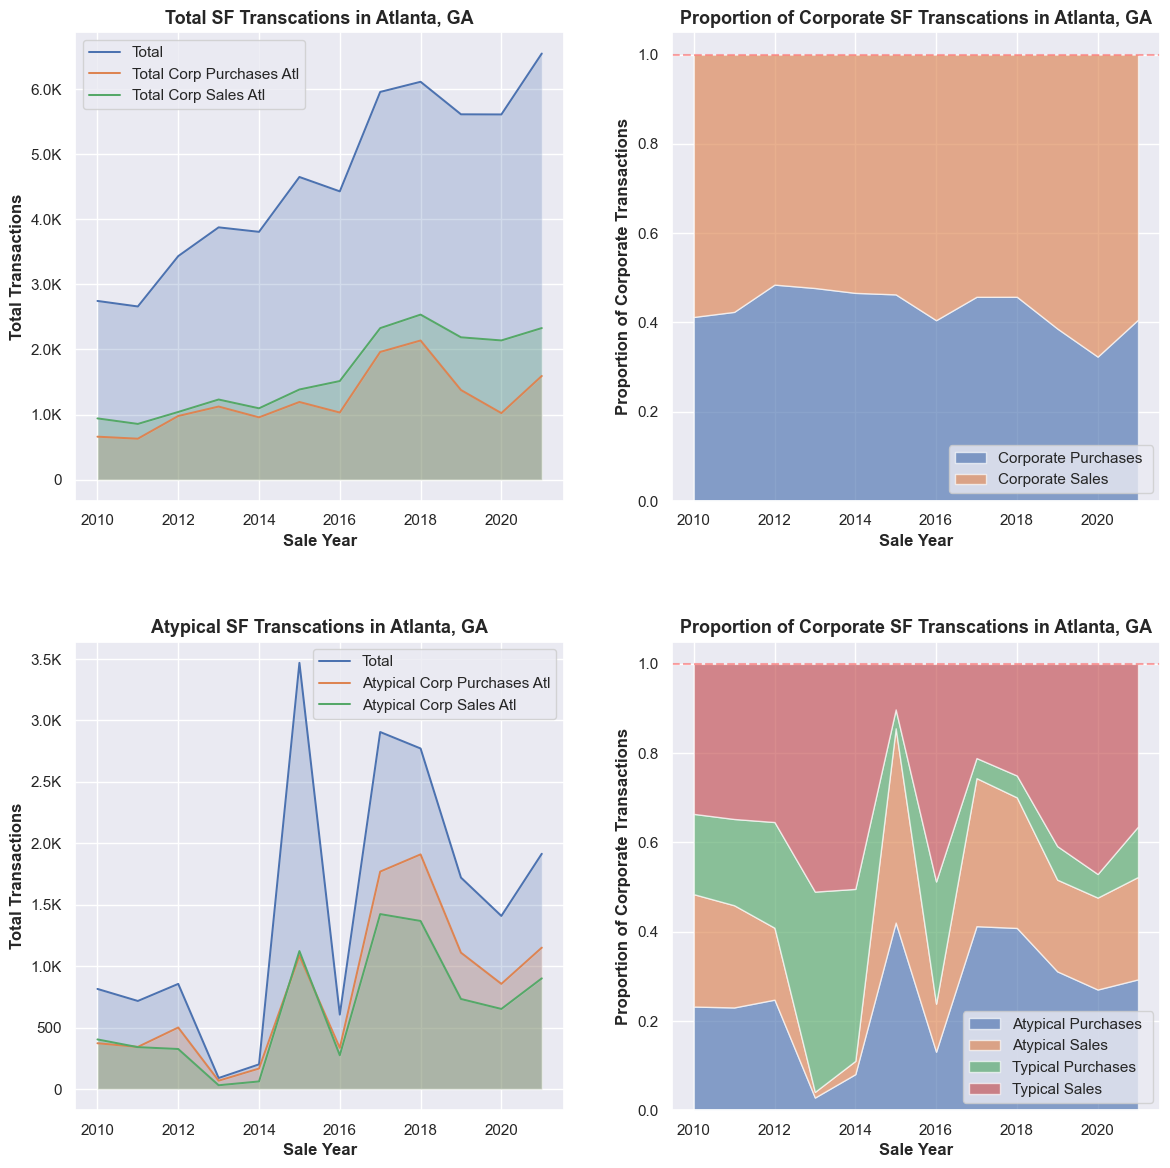

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14), gridspec_kw={'wspace': .22, 'hspace': .3})

for i, subset in enumerate(["Total", "Invalid"]):
    name = "Total"
    if i == 1:
        loc="upper right"
    else:
        loc="upper left"
    if subset == "Invalid":
        name = "Atypical"
    col_labels = ["Total", f"{subset} Corp Purchases Atl", f"{subset} Corp Sales Atl"]
    utils.area_plot(
        total_sales,
        "Sale Year",
        [f"{subset} Atlanta", f"{subset} Corp Purchases Atl", f"{subset} Corp Sales Atl"],
        [x.replace("Invalid", "Atypical") for x in col_labels],
        title=f"{name} SF Transcations in Atlanta, GA",
        x_label="Sale Year",
        y_label="Total Transactions",
        ax=ax[i][0],
        legend={"loc": loc},
        format_func=format_hundreds,
        format_tuple=(0, 1),
    )
    
    stacked_cols = [f"{subset} Corp Purchases Atl %", f"{subset} Corp Sales Atl %"]
    trans_level = " Corporate"
    if subset == "Invalid":
        stacked_cols = [
            "Invalid Corp Purchases Atl % Corp Trans",
            "Invalid Corp Sales Atl % Corp Trans",
            "Valid Corp Purchases Atl % Corp Trans",
            "Valid Corp Sales Atl % Corp Trans"
        ]
        trans_level = " Corporate"
    col_labels = [x.replace("Atl % Corp Trans", "").replace("Atl %", "").replace("Total Corp", "Corporate").replace("Valid", "Typical").replace("Invalid", "Atypical") for x in stacked_cols]
    if subset == "Invalid":
        col_labels = [x.replace(" Corp", "").replace("Valid", "Typical").replace("Invalid", "Atypical") for x in col_labels]


    utils.stacked_plot(
        total_sales,
        "Sale Year",
        stacked_cols,
        col_labels,
        title=f"Proportion of{trans_level} SF Transcations in Atlanta, GA",
        y_label=f"Proportion of{trans_level} Transactions",
        x_label="Sale Year",
        ax=ax[i][1],
        opacity=.65,
        legend={"loc": "lower right"}
    )
    
    ax[i][1].axhline(y=1, color='red', linestyle='--', alpha=.35)

## Sales by Transaction Scale (figure no longer used)

In [8]:
# Note includes valid sales and purchases from govt, bank TODO: do we want to consider?
sale_scale = pd.read_csv("output/sale_scale.csv")
sale_scale["TAXYR"] = (sale_scale["TAXYR"].astype(int) - 1)
sale_scale = sale_scale.rename(columns={"TAXYR": "Sale Year"})

In [9]:
sale_scale.head(3)

Sale Year         entity_addr  Purchases Fulton  Sales Fulton  \
0       2010       0 169TH 11358                 1             0   
1       2010     0 P O BOX 30666                 1             0   
2       2010  0 PO BOX 102 30205                 1             0   

   total_trans_fulton  
0                   1  
1                   1  
2                   1

In [10]:
# Want to join sale_scale to sale so we have scale of both GRANTEE and GRANTOR
sales = sales.merge(
    sale_scale[["Sale Year", "entity_addr", "total_trans_fulton"]],
    left_on=["Sale Year", "GRANTEE_match_addr"], # GRANTEE scale
    right_on=["Sale Year", "entity_addr"],
    how="left"
).rename(columns={"total_trans_fulton": "Buyer Transactions Fulton"}).drop(
    columns=["entity_addr"]
).merge(
    sale_scale[["Sale Year", "entity_addr", "total_trans_fulton"]],
    left_on=["Sale Year", "GRANTOR_match_addr"], # GRANTOR scale
    right_on=["Sale Year", "entity_addr"],
    how="left"
).rename(columns={"total_trans_fulton": "Seller Transactions Fulton"}).drop(
    columns=["entity_addr"]
)

for col in ["Buyer Transactions Fulton", "Seller Transactions Fulton"]:
    sales[col] = sales[col].fillna(0).astype(int)

In [11]:
sales.head(5)[["Sale Year", "GRANTEE_match_addr", "GRANTOR_match_addr", "Buyer Transactions Fulton", "Seller Transactions Fulton"]]

Sale Year     GRANTEE_match_addr       GRANTOR_match_addr  \
0       2017  11340 LAKEFIELD 30097                     <NA>   
1       2017                   <NA>                     <NA>   
2       2021  31 HUDSON YARDS 10001       4651 ROSWELL 30342   
3       2018   1000 ABERNATHY 30328  1580 TERRELL MILL 30067   
4       2018    3694 BRADFORD 30331     1000 ABERNATHY 30328   

   Buyer Transactions Fulton  Seller Transactions Fulton  
0                        161                           0  
1                          0                           0  
2                        185                          82  
3                         95                          37  
4                          1                          95

In [12]:
sales["Buyer Scale"] = sales[
    sales["GRANTEE_corp_flag"] == 1
]["Buyer Transactions Fulton"].apply(classify_corp)

sales["Seller Scale"] = sales[
    sales["GRANTOR_corp_flag"] == 1
]["Seller Transactions Fulton"].apply(classify_corp)

for col in ["Buyer Scale", "Seller Scale"]:
    sales[col] = sales[col].fillna(0).astype(int)

sales_atl = sales[sales["neighborhood"].notna()]
# Add scale metrics to total sales table; e.g. count of sales by scale
# so we want to sum total sales, total valid sales where scale is 1, 2, 3 for each year
dfs = [total_sales] + []

scales = {
    0: "Individual",
    1: "Small Corporate",
    2: "Medium Corporate",
    3: "Large Corporate",
}

names = {
    "Seller": "Sales",
    "Buyer": "Purchases"
}

for trans_type in ["Buyer", "Seller"]:
    for i in scales.keys():
        df = calculate_counts(sales_atl[sales_atl[f"{trans_type} Scale"] == i], f"{scales[i]} {names[trans_type]} Atlanta")
        dfs.append(df)
        
total_sales = reduce(lambda left, right: pd.merge(left, right, on='Sale Year'), dfs)
total_sales

Sale Year  Total  Total Fulton Excl Atl  Valid Fulton Excl Atl  \
0        2010   7126                   4380                   3408   
1        2011   6801                   4140                   2713   
2        2012   9604                   6169                   4837   
3        2013  10503                   6626                   6531   
4        2014  10399                   6591                   6449   
5        2015  12998                   8347                   2393   
6        2016  12485                   8055                   7660   
7        2017  15748                   9790                   7532   
8        2018  16250                  10136                   7866   
9        2019  15758                  10144                   8361   
10       2020  15456                   9844                   8434   
11       2021  17156                  10608                   8516   

    Invalid Fulton Excl Atl  Total Atlanta  Valid Atlanta  Invalid Atlanta  \
0                       972           2746           1932              814   
1                      1427           2661           1945              716   
2                      1332           3435           2580              855   
3                        95           3877           3788               89   
4                       142           3808           3608              200   
5                      5954           4651           1183             3468   
6                       395           4430           3825              605   
7                      2258           5958           3053             2905   
8                      2270           6114           3343             2771   
9                      1783           5614           3894             1720   
10                     1410           5612           4204             1408   
11                     2092           6548           4634             1914   

    Valid Fulton Excl Atl %  Invalid Fulton Excl Atl %  Valid Atlanta %  \
0                   0.47825                    0.13640          0.27112   
1                   0.39891                    0.20982          0.28599   
2                   0.50364                    0.13869          0.26864   
3                   0.62182                    0.00905          0.36066   
4                   0.62016                    0.01366          0.34696   
5                   0.18411                    0.45807          0.09101   
6                   0.61354                    0.03164          0.30637   
7                   0.47828                    0.14338          0.19387   
8                   0.48406                    0.13969          0.20572   
9                   0.53059                    0.11315          0.24711   
10                  0.54568                    0.09123          0.27200   
11                  0.49639                    0.12194          0.27011   

    Invalid Atlanta %  Total Corp Trans Atl  Total Corp Purchases Atl  \
0             0.11423                  1254                       660   
1             0.10528                  1185                       629   
2             0.08903                  1594                       978   
3             0.00847                  1729                      1123   
4             0.01923                  1632                       957   
5             0.26681                  2105                      1193   
6             0.04846                  1999                      1031   
7             0.18447                  3338                      1962   
8             0.17052                  3609                      2138   
9             0.10915                  2965                      1377   
10            0.09110                  2645                      1022   
11            0.11156                  3055                      1593   

    Total Corp Sales Atl  Invalid Corp Purchases Atl  Invalid Corp Sales Atl  \
0                    941                         372                    

In [13]:
pct_cols = [
    "Individual Purchases Atlanta",
    "Small Corporate Purchases Atlanta",
    "Medium Corporate Purchases Atlanta",
    "Large Corporate Purchases Atlanta",
    "Individual Sales Atlanta",
    "Small Corporate Sales Atlanta",
    "Medium Corporate Sales Atlanta",
    "Large Corporate Sales Atlanta"
]

pct_by_type = total_sales[pct_cols].divide(total_sales["Total Atlanta"], axis=0).add_suffix(' %')

total_sales = pd.concat([total_sales, pct_by_type], axis=1)

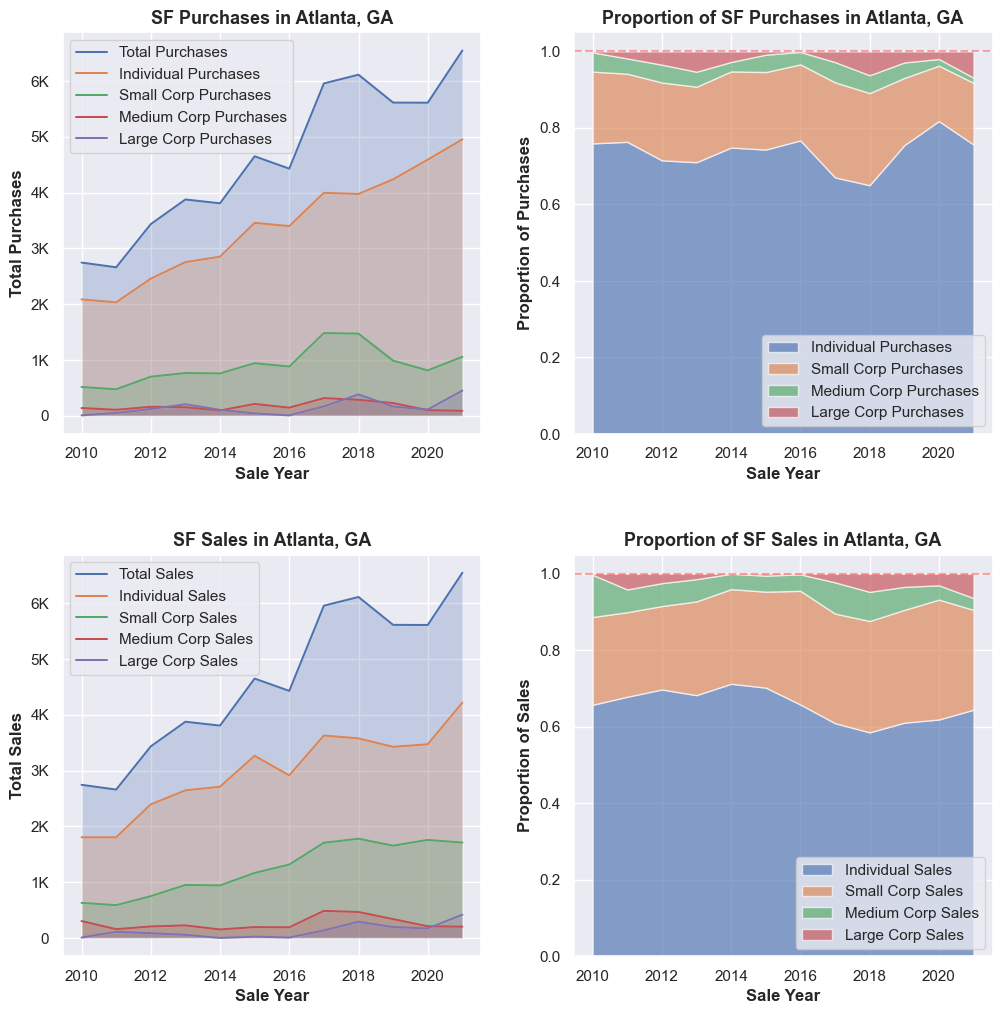

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'wspace': .22, 'hspace': .3})

for i, type in enumerate(["Purchases", "Sales"]):
    utils.area_plot(
        df=total_sales,
        x="Sale Year",
        cols=["Total Atlanta"] + [f"{scales[i]} {type} Atlanta" for i in scales.keys()],
        labels=[f"Total {type}"] + [f"{scales[i]} {type}".replace("Corporate", "Corp") for i in scales.keys()],
        x_label="Sale Year",
        y_label=f"Total {type}",
        title=f"SF {type} in Atlanta, GA",
        ax=ax[i][0],
        format_func=format_thousands,
        format_tuple=(0, 1),
        legend={"loc": "upper left"}
    )
    
    utils.stacked_plot(
        df=total_sales,
        x="Sale Year",
        cols=[f"{scales[i]} {type} Atlanta %" for i in scales.keys()],
        labels=[f"{scales[i]} {type}".replace("Corporate", "Corp") for i in scales.keys()],
        x_label="Sale Year",
        y_label=f"Proportion of {type}",
        title=f"Proportion of SF {type} in Atlanta, GA",
        ax=ax[i][1],
        opacity=.65,
        legend={"loc": "lower right"}
    )
    
    ax[i][1].axhline(y=1, color='red', linestyle='--', alpha=.35)

## Ownership of SFH Rentals (figure no longer used)

In [15]:
owner_scale = pd.read_csv("output/owner_scale.csv")
owner_scale.head(2)

TAXYR             owner_addr  count_owned_fulton_yr  \
0   2010          0 54541 30308                      1   
1   2010  0 99 - 22 215TH 11429                      1   

                      assoc_owner_names  
0                    ['MARSH ADRIAN S']  
1  ['COKLEY JEREL &', 'COKLEY JEREL &']

In [16]:
digest = digest.merge(
    owner_scale[["TAXYR", "owner_addr", "count_owned_fulton_yr"]],
    on=["TAXYR", "owner_addr"],
    how="left"
)

digest["owner scale"] = digest[digest["own_corp_flag"] == 1]["count_owned_fulton_yr"].apply(classify_corp)
digest["owner scale"] = digest["owner scale"].fillna(0).astype(int)

In [17]:
rentals = digest[digest["rental_flag"] == 1]
rentals_atl = rentals[rentals["neighborhood"].notna()]

num_rentals_fulton = calculate_counts(rentals, "Rentals Fulton", group_col="TAXYR")
num_rentals_atl = calculate_counts(rentals_atl, "Rentals Atlanta", group_col="TAXYR")

dfs = [num_rentals_fulton] + [num_rentals_atl] + []

for scale in scales.keys():
    df = calculate_counts(rentals[rentals["owner scale"] == scale], f"{scales[scale]} Fulton", group_col="TAXYR")
    dfs.append(df)
    
    df = calculate_counts(rentals_atl[rentals_atl["owner scale"] == scale], f"{scales[scale]} Atlanta", group_col="TAXYR")
    dfs.append(df)

rental_summary = reduce(lambda left, right: pd.merge(left, right, on='TAXYR'), dfs)

In [18]:
dfs = [rental_summary] + []

pct_cols_fulton = [
    "Individual Fulton",
    "Small Corporate Fulton",
    "Medium Corporate Fulton",
    "Large Corporate Fulton",
]
pct_cols_atl = [
    "Individual Atlanta",
    "Small Corporate Atlanta",
    "Medium Corporate Atlanta",
    "Large Corporate Atlanta"
]

pct_rental_type_fulton = rental_summary[pct_cols_fulton].divide(rental_summary["Rentals Fulton"], axis=0).add_suffix(' %')
pct_rental_type_atl = rental_summary[pct_cols_atl].divide(rental_summary["Rentals Atlanta"], axis=0).add_suffix(' %')

dfs = dfs + [pct_rental_type_fulton, pct_rental_type_atl]

rental_summary = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs)
rental_summary

TAXYR  Rentals Fulton  Rentals Atlanta  Individual Fulton  \
0    2010           38105            21225              28657   
1    2011           39472            21823              29315   
2    2012           39926            21935              29485   
3    2013           41161            22255              29661   
4    2014           42318            22544              29297   
5    2015           42906            22550              28653   
6    2016           39492            22693              25709   
7    2017           43090            22577              27684   
8    2018           42581            22212              26421   
9    2019           42667            22122              25386   
10   2020           42103            21704              24082   
11   2021           40472            20696              22849   
12   2022           40559            20241              21595   

    Individual Atlanta  Small Corporate Fulton  Small Corporate Atlanta  \
0                15396                    5650                     3389   
1                15477                    6025                     3652   
2                15410                    6443                     3896   
3                15277                    6950                     4139   
4                15036                    7291                     4218   
5                14681                    7688                     4405   
6                14473                    7407                     4754   
7                14146                    8493                     4973   
8                13326                    8875                     5339   
9                12618                    9307                     5735   
10               11909                    9468                     5898   
11               11341                    9096                     5658   
12               10675                    9090                     5596   

    Medium Corporate Fulton  Medium Corporate Atlanta  Large Corporate Fulton  \
0                      2442                      1564                    1356   
1                      2609                      1769                    1523   
2                      2769                      1926                    1229   
3                      2924                      1861                    1626   
4                      3221                      2087                    2509   
5                      3447                      2013                    3118   
6                      3610                      2258                    2766   
7                      3820                      2165                    3093   
8                      3408                      1946                    3877   
9                      3812                      2298                    4162   
10                     4076                      2329                    4477   
11                     3642                      2088                    4885   
12                     3424                      2021                    6450   

    Large Corporate Atlanta  Individual Fulton %  Small Corporate Fulton %  \
0                       876              0.75205                   0.14827   
1                       925              0.74268                   0.15264   
2                       703              0.73849                   0.16137   
3                       978              0.72061                   0.16885   
4                      1203              0.69231                   0.17229   
5                      1451              0.66781                   0.17918   
6                      1208              0.65099                   0.18756   
7                      1293              0.64247                   0.19710   
8                      1601              0.62049                   0.20843   
9                      1471              0.59498                   0.21813   
10                     1568              0.57198 

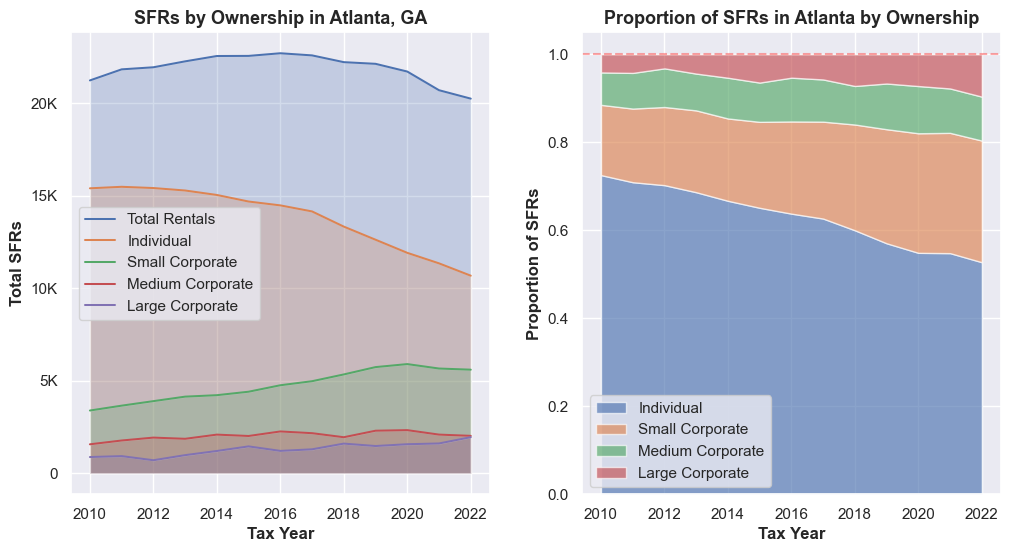

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'wspace': .22, 'hspace': .3})

area = "Atlanta"

utils.area_plot(
    rental_summary,
    "TAXYR",
    [f"Rentals {area}", f"Individual {area}", f"Small Corporate {area}", f"Medium Corporate {area}", f"Large Corporate {area}"],
    [f"Total Rentals", f"Individual", f"Small Corporate", f"Medium Corporate", f"Large Corporate"],
    "Tax Year",
    "Total SFRs",
    f"SFRs by Ownership in {area}, GA",
    legend={"loc": "center left"},
    ax=ax[0],
    format_func=format_thousands,
    format_tuple=(0, 1)
)

utils.stacked_plot(
    rental_summary,
    "TAXYR",
    [f"Individual {area} %", f"Small Corporate {area} %", f"Medium Corporate {area} %", f"Large Corporate {area} %"],
    [f"Individual", f"Small Corporate", f"Medium Corporate", f"Large Corporate"],
    "Tax Year",
    y_label="Proportion of SFRs",
    title=f"Proportion of SFRs in {area} by Ownership",
    legend={"loc": "lower left"},
    ax=ax[1],
    opacity=.65
)

ax[1].axhline(y=1, color='red', linestyle='--', alpha=.35)

## Figure 2. Neighborhood characteristics

In [20]:
nsa_geo.rename(columns={"NEIGHBORHO": "neighborhood"}, inplace=True)
nsa_geo = nsa_geo[['STATISTICA', 'neighborhood', 'geometry']]

nsa_stats.rename(columns={"Details": "neighborhood"}, inplace=True)
nsa_stats = nsa_stats[[
    "GEOID",
    "neighborhood",
    "Median household income 2021",
    "% Not Hispanic Black or African American alone 2021",
]]

nsa_geo = nsa_geo.merge(
    nsa_stats,
    on="neighborhood",
    how="left"
)

dropped_nbhds = [
    'East Lake, The Villages at East Lake',
    'Edgewood',
    'Candler Park, Druid Hills',
    'Kirkwood',
    'Lake Claire',
    'East Atlanta',
    'Airport'
]

nsa_geo = nsa_geo[~nsa_geo["neighborhood"].isin(dropped_nbhds)]

c:\Users\Nick\Documents\code\equity-extraction\utils.py:436: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:436: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:436: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:436: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

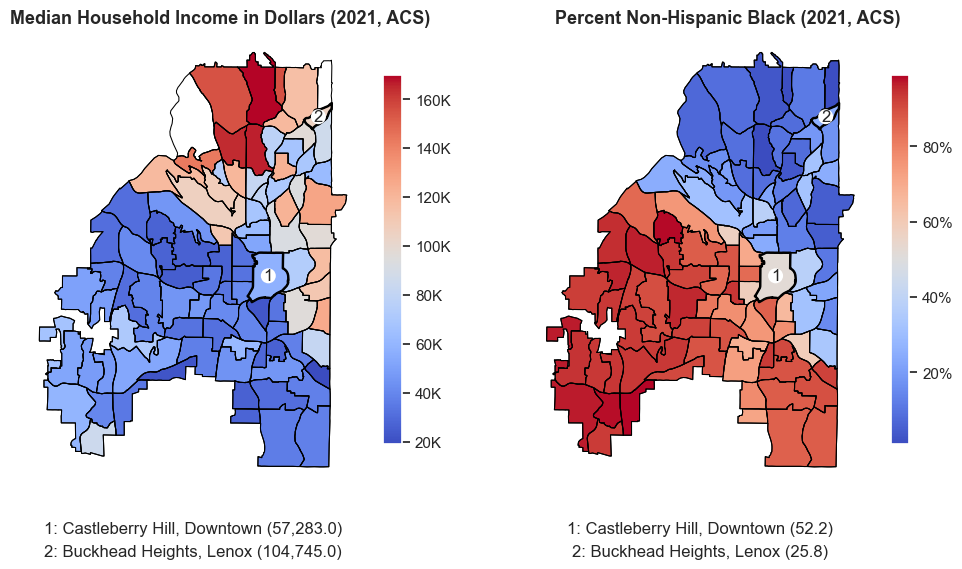

In [21]:
interest = [
    "Thomasville Heights",
    "South Atlanta, The Villages at Carver",
    "Adair Park, Pittsburgh",
    "Sylvan Hills"
]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
hues = [
    "Median household income 2021",
    "% Not Hispanic Black or African American alone 2021",
]
titles = [
    "Median Household Income in Dollars (2021, ACS)",
    "Percent Non-Hispanic Black (2021, ACS)",
]
highlight = [
    "Castleberry Hill, Downtown",
    "Buckhead Heights, Lenox, Ridgedale Park"
    #"Kingswood, Mt. Paran/Northside, Mt. Paran Parkway, Randall Mill, West Paces Ferry/Northside, Whitewater Creek",
    #"Chastain Park, Tuxedo Park",
    #'Adair Park, Pittsburgh',
    #'Lakewood, Leila Valley, Norwood Manor, Rebel Valley Forest',
]

utils.map_select(
    nsa_geo,
    color=hues[0],
    title=titles[0],
    nbhd_df=nsa_geo,
    ax=axes[0],
    highlight=highlight,
    format_func=format_thousands
)

utils.map_select(
    nsa_geo,
    color=hues[1],
    title=titles[1],
    nbhd_df=nsa_geo,
    ax=axes[1],
    highlight=highlight,
    format_func=format_percent
)

## Sales per SFH Parcel, Proportion Valid SFH Sales by Neighborhood (figure no longer used)

In [22]:
dfs = []

dfs.append(calculate_counts(sales_atl, "Total Sales", group_col="neighborhood"))
dfs.append(calculate_counts(invalid_atl, "Invalid Sales", group_col="neighborhood"))
dfs.append(calculate_counts(digest_atl[digest_atl["TAXYR"] == 2022], "Total Parcels 2022", group_col="neighborhood"))

atl_sales_summary = reduce(lambda left, right: pd.merge(left, right, on='neighborhood'), dfs)

atl_sales_summary["Sales Per Parcel"] = atl_sales_summary["Total Sales"].divide(atl_sales_summary["Total Parcels 2022"], axis=0)
atl_sales_summary["Percent Invalid Sales"] = atl_sales_summary["Invalid Sales"].divide(atl_sales_summary["Total Sales"], axis=0)
atl_sales_summary = atl_sales_summary.merge(nsa_geo[["neighborhood", "geometry"]], on="neighborhood", how="left")

atl_sales_summary.sort_values("Sales Per Parcel", ascending=False).head(3)

neighborhood  Total Sales  \
68                                  Lindbergh/Morosgo           88   
24               Berkeley Park, Blandtown, Hills Park         1106   
47  Collier Hills, Collier Hills North, Colonial H...          441   

    Invalid Sales  Total Parcels 2022  Sales Per Parcel  \
68             16                  55           1.60000   
24            163                 937           1.18036   
47             46                 405           1.08889   

    Percent Invalid Sales                                           geometry  
68                0.18182  POLYGON ((-84.37344 33.81581, -84.37316 33.815...  
24                0.14738  POLYGON ((-84.40828 33.78821, -84.40767 33.788...  
47                0.10431  POLYGON ((-84.38923 33.81761, -84.38916 33.817...

c:\Users\Nick\Documents\code\equity-extraction\utils.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",


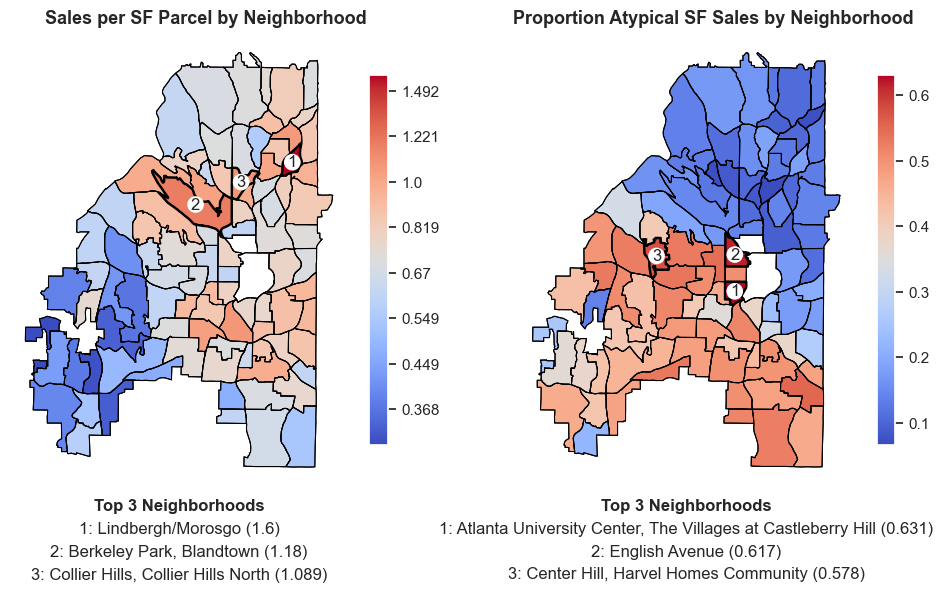

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

atl_sales_summary = atl_sales_summary.fillna(0)
#outliers_1 = ["Georgia Tech, Marietta Street Artery", "Lindbergh/Morosgo"]
highlight1 = [
    'Carver Hills, Rockdale, Scotts Crossing, West Highlands',
    'Lindbergh/Morosgo',
    'Adair Park, Pittsburgh',
]
highlight2 = [
    "English Avenue",
    'Atlanta University Center, The Villages at Castleberry Hill',
    'Center Hill, Harvel Homes Community',
]
utils.map(
    atl_sales_summary,
    color="Sales Per Parcel",
    title="Sales per SF Parcel by Neighborhood",
    nbhd_df=nsa_geo,
    ax=ax[0],
    log=True,
    highlight=highlight1,
)

utils.map(
    atl_sales_summary,
    color="Percent Invalid Sales",
    title="Proportion Atypical SF Sales by Neighborhood",
    nbhd_df=nsa_geo,
    ax=ax[1],
    highlight=highlight2,
)

## Figure 3. Proportion Owned by Corporate Size

In [24]:
digest_atl_2022 = digest[(digest["TAXYR"] == 2022) & (digest["neighborhood"].notna())]
print(len(digest_atl_2022))

dfs = [calculate_counts(digest_atl_2022, "Total Parcels 2022", group_col="neighborhood")] + []

for scale in scales:
    df = calculate_counts(
        digest_atl_2022[digest_atl_2022["owner scale"] == scale],
        f"{scales[scale]}",
        group_col="neighborhood"
    )
    
    dfs.append(df)
    
ownership_2022 = reduce(lambda left, right: pd.merge(left, right, on="neighborhood", how="left"), dfs)
ownership_2022 = ownership_2022.fillna(0)

pct_cols = [f"{scales[i]}" for i in scales.keys()]
pct_by_owner = ownership_2022[pct_cols].divide(ownership_2022["Total Parcels 2022"], axis=0).add_suffix(' %')
ownership_2022 = pd.concat([ownership_2022, pct_by_owner], axis=1)

ownership_2022 = ownership_2022.merge(
    nsa_geo[["neighborhood", "geometry"]],
    on="neighborhood",
    how="left"
)

ownership_2022.sort_values(by="Large Corporate %", ascending=False).head(3)

77042


neighborhood  Total Parcels 2022  \
18                          Bankhead, Washington Park                 893   
88                                South River Gardens                 607   
21  Ben Hill Forest, Ben Hill Pines, Brentwood, De...                 735   

    Individual  Small Corporate  Medium Corporate  Large Corporate  \
18         577        157.00000          70.00000         89.00000   
88         477         47.00000          26.00000         57.00000   
21         606         49.00000          16.00000         64.00000   

    Individual %  Small Corporate %  Medium Corporate %  Large Corporate %  \
18       0.64614            0.17581             0.07839            0.09966   
88       0.78583            0.07743             0.04283            0.09390   
21       0.82449            0.06667             0.02177            0.08707   

                                             geometry  
18  POLYGON ((-84.41751 33.76043, -84.41749 33.762...  
88  POLYGON ((-84.34953 33.67601, -84.34943 33.678...  
21  POLYGON ((-84.50837 33.69009, -84.50841 33.690...

In [25]:
# Proportion of parcels owned by individuals
digest_atl_2022[digest_atl_2022["own_corp_flag"] != 1]["PARID"].count() / digest_atl_2022["PARID"].count()

0.8646582383634901

c:\Users\Nick\Documents\code\equity-extraction\utils.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

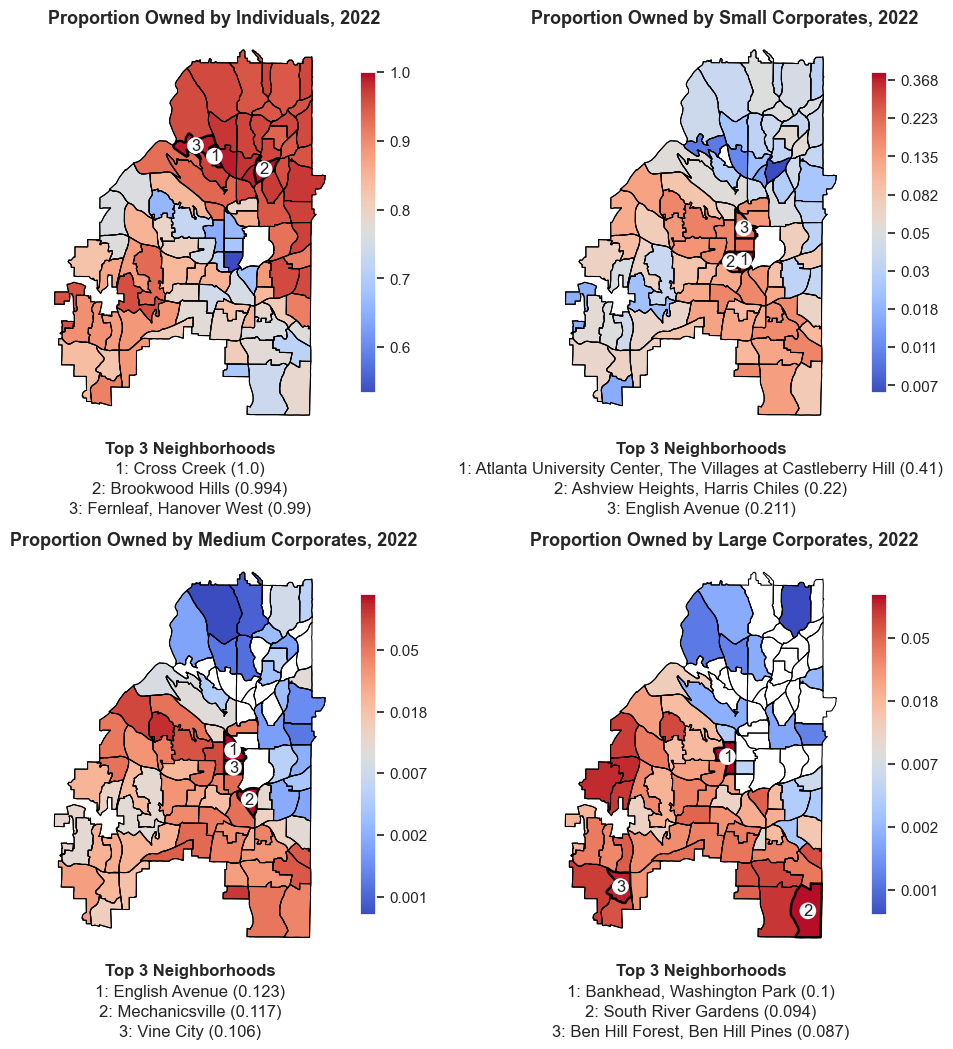

In [26]:
# TODO: make 0 grayed out (could just plot a map underneath)
fig, ax = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'wspace': .22, 'hspace': .3})

highlight = [
    [
        "English Avenue",
        'Lakewood, Leila Valley, Norwood Manor, Rebel Valley Forest',
    ],
    [
        'Atlanta University Center, The Villages at Castleberry Hill',
        'Lakewood, Leila Valley, Norwood Manor, Rebel Valley Forest',
    ],
    [
        "English Avenue",
        "Mechanicsville",
    ],
    [
        "South River Gardens",
         'Baker Hills, Bakers Ferry, Boulder Park, Fairburn Road/Wisteria Lane, Ridgecrest Forest, Wildwood (NPU-H), Wilson Mill Meadows, Wisteria Gardens',
    ]
]

log=False
for i, scale in enumerate(scales.values()):
    # neighborhoods we already excluded
    if i in [1, 2, 3]:
        log=True
    else:
        log=False
    utils.map(
        ownership_2022[~ownership_2022["neighborhood"].str.contains("Downtown")],
        color=f"{scale} %",
        title=f"Proportion Owned by {scale}s, 2022",
        nbhd_df=nsa_geo,
        ax=ax.flatten()[i],
        log=log,
        highlight=highlight[i],
    )

## Figure 4. Percent of Sales by Sale Type and Neighborhood

In [27]:
dfs = [] + [atl_sales_summary]

sale_types = ["corp_bought_ind", "corp_sold_ind", "ind_to_ind", "corp_to_corp"]
for sale in sale_types:
    dfs.append(pd.DataFrame(sales_atl[
        sales_atl[sale] == 1
    ].groupby("neighborhood")["PARID"].count()).rename(columns={"PARID": f"Total {sale}"}).reset_index())
    
atl_sales_summary = reduce(lambda left, right: pd.merge(left, right, on="neighborhood", how="left"), dfs)

atl_sales_summary = atl_sales_summary.fillna(0)
atl_sales_summary['Percent corp_bought_ind'] = atl_sales_summary['Total corp_bought_ind'] / atl_sales_summary['Total Sales']
atl_sales_summary['Percent corp_sold_ind'] = atl_sales_summary['Total corp_sold_ind'] / atl_sales_summary['Total Sales']
atl_sales_summary['Percent ind_to_ind'] = atl_sales_summary['Total ind_to_ind'] / atl_sales_summary['Total Sales']
atl_sales_summary['Percent corp_to_corp'] = atl_sales_summary['Total corp_to_corp'] / atl_sales_summary['Total Sales']
atl_sales_summary.sort_values(by="Percent corp_bought_ind", ascending=False).head(5)

neighborhood  Total Sales  \
59                                       Hammond Park          247   
81                                          Perkerson          226   
17  Bankhead Courts, Bankhead/Bolton, Carroll Heig...          585   
18                          Bankhead, Washington Park          564   
25  Blair Villa/Poole Creek, Glenrose Heights, Orc...          779   

    Invalid Sales  Total Parcels 2022  Sales Per Parcel  \
59            128                 407           0.60688   
81            114                 480           0.47083   
17            290                 972           0.60185   
18            307                 893           0.63158   
25            408                1177           0.66185   

    Percent Invalid Sales                                           geometry  \
59                0.51822  POLYGON ((-84.41657 33.67310, -84.41427 33.673...   
81                0.50442  POLYGON ((-84.41669 33.68137, -84.41596 33.681...   
17                0.49573  POLYGON ((-84.51545 33.76516, -84.51535 33.765...   
18                0.54433  POLYGON ((-84.41751 33.76043, -84.41749 33.762...   
25                0.52375  POLYGON ((-84.39123 33.64812, -84.39122 33.648...   

    Total corp_bought_ind  Total corp_sold_ind  Total ind_to_ind  \
59               79.00000                   71                66   
81               60.00000                   46                71   
17              148.00000                  128               143   
18              142.00000                  154               135   
25              191.00000                  209               169   

    Total corp_to_corp  Percent corp_bought_ind  Percent corp_sold_ind  \
59            31.00000                  0.31984                0.28745   
81            49.00000                  0.26549                0.20354   
17           166.00000                  0.25299                0.21880   
18           133.00000                  0.25177                0.27305   
25           210.00000                  0.24519                0.26829   

    Percent ind_to_ind  Percent corp_to_corp  
59             0.26721               0.12551  
81             0.31416               0.21681  
17             0.24444               0.28376  
18             0.23936               0.23582  
25             0.21694               0.26958

c:\Users\Nick\Documents\code\equity-extraction\utils.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

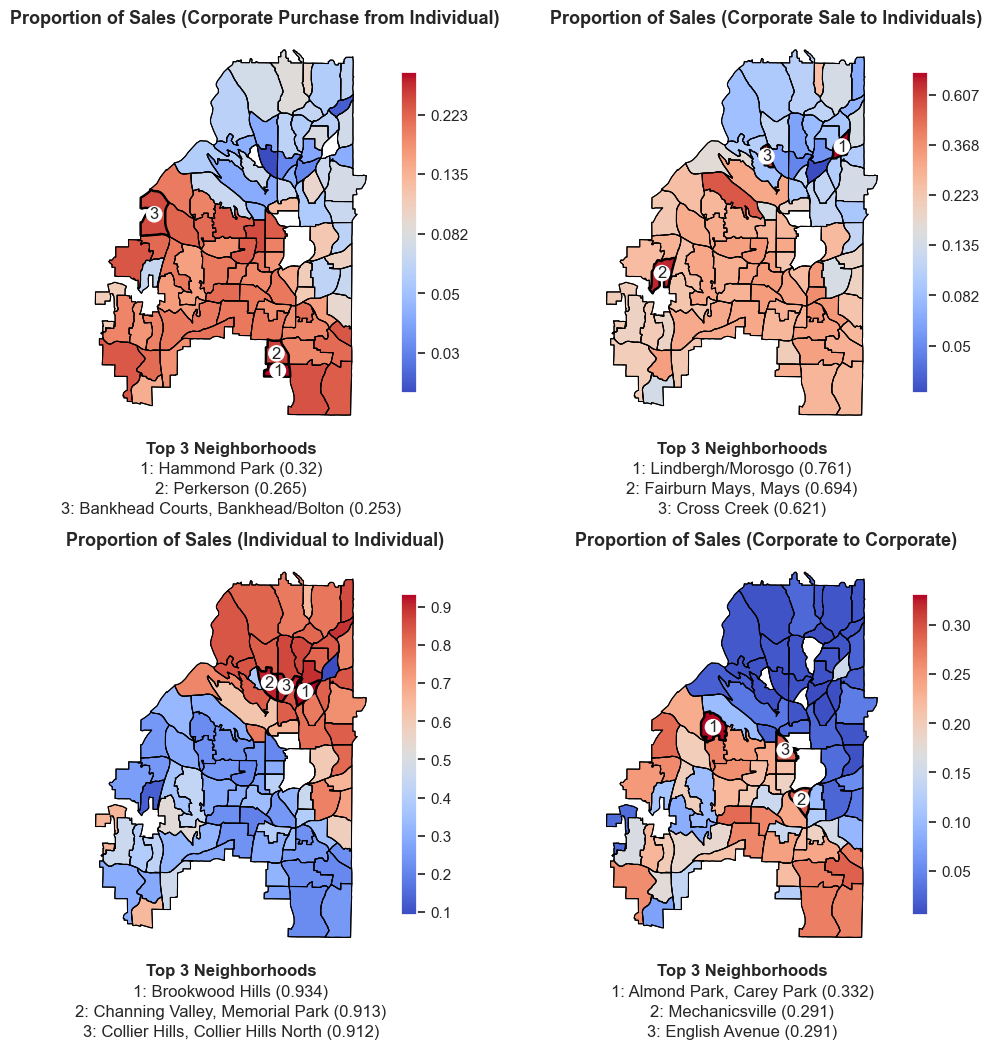

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'wspace': .22, 'hspace': .3})

highlight1 = [
    "Hammond Park",
    'Bankhead Courts, Bankhead/Bolton, Carroll Heights, Fairburn Heights, Old Gordon',
]

highlight2 = [
    "Lindbergh/Morosgo",
    "Carver Hills, Rockdale, Scotts Crossing, West Highlands",
    "Fairburn Mays, Mays",
]

highlight3 = [
    'Collier Hills, Collier Hills North, Colonial Homes',
    'Grant Park, Oakland',
]

highlight4 = [
    "Almond Park, Carey Park",
    "Lakewood, Leila Valley, Norwood Manor, Rebel Valley Forest",
]

utils.map(
    atl_sales_summary,
    color="Percent corp_bought_ind",
    title="Proportion of Sales (Corporate Purchase from Individual)",
    nbhd_df=nsa_geo,
    ax=ax[0][0],
    log=True,
    highlight=highlight1
)
utils.map(
    atl_sales_summary,
    color="Percent corp_sold_ind",
    title="Proportion of Sales (Corporate Sale to Individuals)",
    nbhd_df=nsa_geo,
    ax=ax[0][1],
    log=True,
    highlight=highlight2
)
utils.map(
    atl_sales_summary,
    color="Percent ind_to_ind",
    title="Proportion of Sales (Individual to Individual)",
    nbhd_df=nsa_geo,
    ax=ax[1][0],
    highlight=highlight3
)
utils.map(
    atl_sales_summary,
    color="Percent corp_to_corp",
    title="Proportion of Sales (Corporate to Corporate)",
    nbhd_df=nsa_geo,
    ax=ax[1][1],
    highlight=highlight4
)

## Majority-Black vs Other Neighborhoods by Corporate Purchases and Sales (figure no longer used)

In [29]:
# Separate neighborhoods into majority Black and other with mb_flag
mb_neighborhoods = nsa_geo[
    nsa_geo["% Not Hispanic Black or African American alone 2021"] >= 50
]["neighborhood"].unique()

sales["mb_flag"] = sales["neighborhood"].apply(lambda x: 1 if x in mb_neighborhoods else 0)
# Agg all sales on mb_flag, calculate total transcations, number where buyer is corp,
# seller is corp, buyer is corp and seller is corp, then calculate percent
total_sales = calculate_counts(sales, "total_sales", group_col=["mb_flag", "Sale Year"])

all_corp_trans = sales[(sales["GRANTEE_corp_flag"] == 1) | (sales["GRANTOR_corp_flag"] == 1)]
corp_trans = calculate_counts(all_corp_trans, "corp_trans", group_col=["mb_flag", "Sale Year"])

mb_summary = total_sales.merge(corp_trans, on=["mb_flag", "Sale Year"], how="left")
mb_summary["% corp"] = mb_summary["corp_trans"] / mb_summary["total_sales"]

In [30]:
# total value of nbhd
digest_atl_2022["mb_flag"] = digest_atl_2022["neighborhood"].apply(lambda x: 1 if x in mb_neighborhoods else 0)
len(digest_atl_2022)
digest_atl_2022.groupby("mb_flag")["Aprtot"].sum()

C:\Users\Nick\AppData\Local\Temp\ipykernel_23568\1875785571.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  digest_atl_2022["mb_flag"] = digest_atl_2022["neighborhood"].apply(lambda x: 1 if x in mb_neighborhoods else 0)


mb_flag
0   28,269,399,206.00000
1   10,107,813,433.00000
Name: Aprtot, dtype: float64

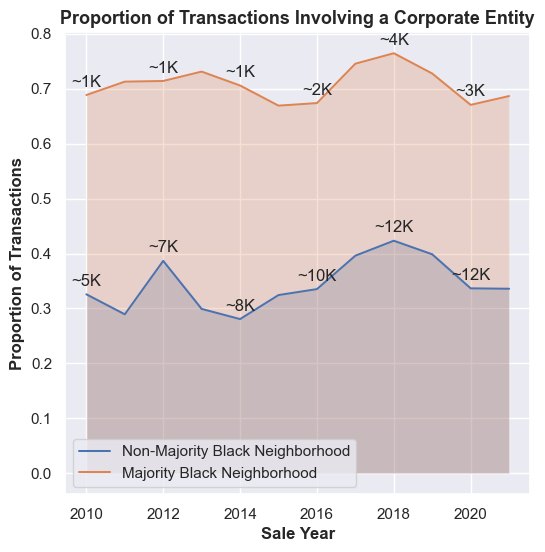

In [31]:
# TODO add in corp to corp / invalid
# TODO for each point, put absolute numbers

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

utils.area_plot(
    mb_summary[mb_summary["mb_flag"] == 0],
    "Sale Year",
    ["% corp"],
    ["Non-Majority Black Neighborhood"],
    "Sale Year",
    title="Proportion of Transactions Involving a Corporate Entity",
    ax=ax,
    legend={"loc": "lower left"},
    ann="total_sales"
)

utils.area_plot(
    mb_summary[mb_summary["mb_flag"] == 1],
    "Sale Year",
    ["% corp"],
    ["Majority Black Neighborhood"],
    "Sale Year",
    "Proportion of Transactions",
    ax=ax,
    legend={"loc": "lower left"},
    ann="total_sales"
)

---
## Equity Loss Figures

## Calculation by Year
Drop outliers where sale_diff is too extreme (multi-parcel sales with properties outside Fulton most likely) -- should note this

In [32]:
# sale_diff = fmv_adj - price_adj
sales["sale_diff_adj"] = sales["fmv_adj"] - sales["price_adj"]
sales["sale_diff"] = sales["FAIR MARKET VALUE"] - sales["sales_price"]
original_sales = sales.copy(deep=True)

# Calculate the 99th percentile of sale_diff
top_threshold = sales["sale_diff_adj"].quantile(0.99)
bottom_threshold = sales["sale_diff_adj"].quantile(0.01)

# Filter out the rows where sale_diff is greater than the threshold
sales = sales[
    (sales["sale_diff_adj"] < top_threshold)
    & (sales["sale_diff_adj"] > bottom_threshold)
]
dropped_sales = original_sales[(original_sales["sale_diff_adj"] >= top_threshold) | (original_sales["sale_diff_adj"] <= bottom_threshold)]

In [33]:
def agg(df, label, agg_col, group_col='Sale Year'):
    if isinstance(group_col, list):
        return df.groupby(by=group_col)[agg_col].sum().reset_index(name=label)
    else:
        return df.groupby(by=[group_col])[agg_col].sum().reset_index(name=label)
    
# sale loss: aggregate sale_diff where corp_sold_ind = 1
# positive indicates sold for below FMV, company contributed to neighborhood equity
dfs = []
atl_sales = sales[sales["neighborhood"].notna()]

dfs.append(agg(atl_sales[atl_sales["corp_sold_ind"] == 1], "sale_loss_adj", "sale_diff_adj", group_col=["TAXYR", "neighborhood"]))
dfs.append(agg(atl_sales[atl_sales["corp_bought_ind"] == 1], "purchase_loss_adj", "sale_diff_adj", group_col=["TAXYR", "neighborhood"]))

dfs.append(agg(atl_sales[atl_sales["corp_sold_ind"] == 1], "sale_loss", "sale_diff", group_col=["TAXYR", "neighborhood"]))
dfs.append(agg(atl_sales[atl_sales["corp_bought_ind"] == 1], "purchase_loss", "sale_diff", group_col=["TAXYR", "neighborhood"]))

# rental loss: sum of aprtot_adj * .005 * 12 where rental_flag = 1 and own_corp_flag = 1
digest["rental_value_adj"] = digest["Aprtot_adj"] * .005 * 12
digest["rental_value"] = digest["Aprtot"] * .005 * 12

# ignore 2022 rental loss, since sale data ends at 2021
rental_loss_digest = digest[
    (digest["neighborhood"].notna())
    & (digest["rental_flag"] == 1)
    & (digest["own_corp_flag"] == 1)
    & (digest["TAXYR"] < 2022)
]
dfs.append(agg(rental_loss_digest, "rental_loss_adj", "rental_value_adj", group_col=["TAXYR", "neighborhood"]))
dfs.append(agg(rental_loss_digest, "rental_loss", "rental_value", group_col=["TAXYR", "neighborhood"]))

equity_summary = reduce(lambda left, right: pd.merge(left, right, on=["TAXYR", "neighborhood"], how="left"), dfs)

# flip sign so negative is contributing, positive is loss
equity_summary["sale_loss_adj"] = -equity_summary["sale_loss_adj"]
equity_summary["total_loss_adj"] = equity_summary["sale_loss_adj"] + equity_summary["purchase_loss_adj"] + equity_summary["rental_loss_adj"]

equity_summary["sale_loss"] = -equity_summary["sale_loss"]
equity_summary["total_loss"] = equity_summary["sale_loss"] + equity_summary["purchase_loss"] + equity_summary["rental_loss"]

equity_summary = equity_summary.merge(
    nsa_geo,
    on="neighborhood",
    how="left"
)
equity_summary.head(3)

TAXYR                           neighborhood  sale_loss_adj  \
0   2011                 Adair Park, Pittsburgh  710,727.65467   
1   2011  Adams Park, Laurens Valley, Southwest  191,609.48585   
2   2011                   Adamsville, Oakcliff  -82,940.50183   

   purchase_loss_adj     sale_loss  purchase_loss  rental_loss_adj  \
0      284,190.94648 524,859.00000  209,869.66667  1,022,765.99718   
1      -33,113.91072 141,500.00000  -24,454.00000    427,316.02955   
2       51,924.13947 -61,250.00000   38,345.00000    269,612.44015   

    rental_loss  total_loss_adj      total_loss STATISTICA  \
0 777,668.40000 2,017,684.59832 1,512,397.06667        V02   
1 324,913.20000   585,811.60468   441,959.20000        R02   
2 205,002.00000   238,596.07780   182,097.00000        H02   

                                            geometry GEOID  \
0  POLYGON ((-84.40535 33.74403, -84.40447 33.744...   V02   
1  POLYGON ((-84.47248 33.70263, -84.47117 33.702...   R02   
2  POLYGON ((-84.50829 33.74873, -84.50820 33.748...   H02   

   Median household income 2021  \
0                  39,353.00000   
1                  53,069.00000   
2                  38,142.00000   

   % Not Hispanic Black or African American alone 2021  
0                                           75.20000    
1                                           93.60000    
2                                           96.00000

In [35]:
household_data = pd.read_csv("data/atl_nsa_households.csv", skiprows=1).rename(columns={"Details": "neighborhood"})
household_data.head(2)

GEOID                                       neighborhood  \
0   A01            Margaret Mitchell, Paces, Pleasant Hill   
1   A02  Kingswood, Mt. Paran/Northside, Mt. Paran Park...   

   Average household size 2021  Median household income 2021  \
0                      2.40000                           NaN   
1                      2.20000                 154,720.00000   

   # Age 18 years and over 2021  # Age 21 years and over 2021  \
0                          2981                          2930   
1                          3555                          3496   

   # Total households 2021  
0                     1660  
1                     2019

## Total Calculation

In [36]:
dfs = []
dfs.append(agg(equity_summary, "sale_loss_adj", "sale_loss_adj", group_col=["neighborhood"]))
dfs.append(agg(equity_summary, "purchase_loss_adj", "purchase_loss_adj", group_col=["neighborhood"]))
dfs.append(agg(equity_summary, "rental_loss_adj", "rental_loss_adj", group_col=["neighborhood"]))

dfs.append(agg(equity_summary, "sale_loss", "sale_loss", group_col=["neighborhood"]))
dfs.append(agg(equity_summary, "purchase_loss", "purchase_loss", group_col=["neighborhood"]))
dfs.append(agg(equity_summary, "rental_loss", "rental_loss", group_col=["neighborhood"]))

total_equity = reduce(lambda left, right: pd.merge(left, right, on="neighborhood", how="left"), dfs)
total_equity = total_equity.fillna(0)

total_equity["total_loss_adj"] = total_equity["sale_loss_adj"] + total_equity["purchase_loss_adj"] + total_equity["rental_loss_adj"]
total_equity["total_loss"] = total_equity["sale_loss"] + total_equity["purchase_loss"] + total_equity["rental_loss"]

total_equity = total_equity.merge(
    nsa_geo,
    on="neighborhood",
    how="left"
).merge(
    household_data[["neighborhood", "Average household size 2021", "# Total households 2021"]],
    on="neighborhood",
    how="left"
)

In [41]:
total_equity[total_equity["rental_loss_adj"] > 0].sort_values("total_loss_adj", ascending=False).head(4)

neighborhood    sale_loss_adj  \
65  Kingswood, Mt. Paran/Northside, Mt. Paran Park...  7,382,099.95390   
75                             Morningside/Lenox Park 18,938,192.98236   
76                                     North Buckhead 13,394,667.44360   
57                                Grant Park, Oakland 17,177,680.61545   

    purchase_loss_adj  rental_loss_adj        sale_loss    purchase_loss  \
65   -3,883,072.97139 40,146,641.88088  6,335,570.00000 -3,223,707.00000   
75     -301,090.64381 19,408,225.56397 15,475,847.00000   -295,877.00000   
76     -433,572.34113 23,387,035.15143 11,003,022.00000   -386,910.00000   
57    3,994,645.47694 14,409,657.16600 13,935,537.00000  3,157,858.00000   

        rental_loss   total_loss_adj       total_loss STATISTICA  \
65 33,592,459.20000 43,645,668.86339 36,704,322.20000        A02   
75 16,254,778.80000 38,045,327.90251 31,434,748.80000        F04   
76 19,617,727.80000 36,348,130.25391 30,233,839.80000        B04   
57 12,120,608.40000 35,581,983.25839 29,214,003.40000        W01   

                                             geometry GEOID  \
65  POLYGON ((-84.40725 33.84953, -84.40723 33.850...   A02   
75  POLYGON ((-84.33840 33.80105, -84.33803 33.802...   F04   
76  POLYGON ((-84.38051 33.87572, -84.38064 33.875...   B04   
57  POLYGON ((-84.38070 33.74742, -84.38072 33.746...   W01   

    Median household income 2021  \
65                 154,720.00000   
75                 127,788.00000   
76                 115,841.00000   
57                  95,867.00000   

    % Not Hispanic Black or African American alone 2021  \
65                                            8.70000     
75                                            4.90000     
76                                           11.40000     
57                                           31.60000     

    Average household size 2021  # Total households 2021  
65                      2.20000                     2019  
75                      2.20000                     4748  
76                      1.90000                     6142  
57                      2.10000                     3967

## Total Equity Loss Calculation (Sum)

In [42]:
total_equity["total_loss_adj"].mean()

13292653.387131805

In [43]:
f"{total_equity["total_loss_adj"].sum():,.0f}"

'1,249,509,418'

## Investigation into Top Rental Loss Neighborhood

In [45]:
digest[
    (digest["neighborhood"].str.contains("Kingswood"))
    & (digest["rental_flag"] == 1)
    & (digest["own_corp_flag"] == 1)
][["PARID", "Situs Adrno", "Situs Adrstr", "owner_addr", "Own1", "Aprtot_adj", "rental_value", "TAXYR"]].sort_values("rental_value", ascending=False).head(10)

PARID  Situs Adrno Situs Adrstr                 owner_addr  \
2738202  17 0201  LL0044         4270       HARRIS         0 PO BOX 781 34216   
2738201  17 0201  LL0044         4270       HARRIS         0 PO BOX 781 34216   
2738203  17 0201  LL0044         4270       HARRIS         0 PO BOX 781 34216   
2738398  17 0160  LL0985          830  WEST CONWAY  109453324 PEACHTREE 30326   
2738399  17 0160  LL0985          830  WEST CONWAY  109453324 PEACHTREE 30326   
1596112  17 0140  LL0030         3800    NORTHSIDE          1235 DUTTON 95401   
1596314  17 0140  LL0030         3800    NORTHSIDE          1235 DUTTON 95401   
2737862  17 016100020171         4370        PARAN       3647 CLOUDLAND 30327   
1596196  17 0140  LL0030         3800    NORTHSIDE          1235 DUTTON 95401   
2736542  17 016000020131          815    FAIRFIELD          2 CONCOURSE 30328   

                                     Own1       Aprtot_adj  rental_value  \
2738202                  GREEN BIKINI LLC 12,932,753.17306 681,000.00000   
2738201                  GREEN BIKINI LLC  9,634,600.00000 578,076.00000   
2738203                  GREEN BIKINI LLC  9,957,638.24614 561,234.00000   
2738398  PACIFIC DEVELOPMENT PARTNERS LLC 11,507,735.78468 525,000.00000   
2738399  PACIFIC DEVELOPMENT PARTNERS LLC 11,310,812.01737 525,000.00000   
1596112          3800 NORTHSIDE DRIVE LLC  9,594,211.86307 498,414.00000   
1596314          3800 NORTHSIDE DRIVE LLC  9,180,596.68276 466,272.00000   
2737862                   PARAN PLACE LLC  7,569,533.99886 356,622.00000   
1596196          3800 NORTHSIDE DRIVE LLC  7,078,852.36569 352,788.00000   
2736542               DRE INVESTMENTS LLC  5,681,500.00000 340,890.00000   

         TAXYR  
2738202   2020  
2738201   2022  
2738203   2021  
2738398   2011  
2738399   2012  
1596112   2019  
1596314   2018  
2737862   2013  
1596196   2017  
2736542   2022

In [46]:
total_equity.sort_values(by="total_loss_adj", ascending=True).head(4)

neighborhood  sale_loss_adj  purchase_loss_adj  \
42               Castleberry Hill, Downtown       68.36698            0.00000   
29                          Brookwood Hills  841,762.16585     -719,245.73093   
7                        Ardmore, Brookwood  923,887.77585      123,296.95715   
32  Buckhead Heights, Lenox, Ridgedale Park  445,238.61345            0.00000   

    rental_loss_adj     sale_loss  purchase_loss   rental_loss  \
42     31,291.20673      60.00000        0.00000  29,394.00000   
29    425,220.83976 728,900.00000 -603,600.00000 351,474.00000   
7     328,624.53080 750,371.00000  101,140.00000 272,288.40000   
32  1,096,620.39764 357,381.00000        0.00000 920,628.00000   

    total_loss_adj      total_loss STATISTICA  \
42    31,359.57370    29,454.00000        M01   
29   547,737.27469   476,774.00000        E05   
7  1,375,809.26380 1,123,799.40000        E03   
32 1,541,859.01109 1,278,009.00000        B06   

                                             geometry GEOID  \
42  POLYGON ((-84.40038 33.77067, -84.40090 33.770...   M01   
29  POLYGON ((-84.38906 33.81767, -84.38916 33.817...   E05   
7   POLYGON ((-84.39369 33.79628, -84.39367 33.796...   E03   
32  POLYGON ((-84.36774 33.84746, -84.36765 33.847...   B06   

    Median household income 2021  \
42                  57,283.00000   
29                  70,213.00000   
7                   80,051.00000   
32                 104,745.00000   

    % Not Hispanic Black or African American alone 2021  \
42                                           52.20000     
29                                           12.00000     
7                                            22.40000     
32                                           25.80000     

    Average household size 2021  # Total households 2021  
42                      1.40000                     7312  
29                      1.90000                     1802  
7                       1.70000                     2076  
32                      1.50000                     2689

## Total equity loss for each year (aggregate calculation)
We want equity loss of every transaction, agg by year and entity_addr
then merge year and entity_agg with total_trans_fulton (sale scale)

In [ ]:
corp_involved_sales = sales[
    ((sales["corp_sold_ind"] == 1)
    | (sales["corp_bought_ind"] == 1))
    & (sales["neighborhood"].notna())
]
print(corp_involved_sales)
corp_involved_sales["sale_loss_adj"] = corp_involved_sales.apply(lambda row: -row["sale_diff_adj"] if row["corp_sold_ind"] == 1 else 0, axis=1)
corp_involved_sales["purchase_loss_adj"] = corp_involved_sales.apply(lambda row: row["sale_diff_adj"] if row["corp_bought_ind"] == 1 else 0, axis=1)
corp_involved_sales["total_loss_adj"] = corp_involved_sales["sale_loss_adj"].astype("float") + corp_involved_sales["purchase_loss_adj"].astype("float")

corp_involved_sales["corp_match"] = corp_involved_sales.apply(lambda row: row["GRANTOR_match_addr"] if row["corp_sold_ind"] == 1 else row["GRANTEE_match_addr"], axis=1)

corp_involved_sales.sample(5)[[
    "TAXYR", "sales_price", "FAIR MARKET VALUE", "sale_diff", "sale_diff_adj", "GRANTEE", "GRANTOR", "corp_match", "corp_sold_ind", "corp_bought_ind",
    "sale_loss_adj", "purchase_loss_adj", "total_loss_adj",
]]

        TAXYR            PARID  Luc       Saledt   SALES PRICE  \
4        2019  14F0004  LL0507  101  07-DEC-2018 252,900.00000   
133      2019  14F001400050491  101  13-JUN-2018 114,000.00000   
251      2018  14 002500020059  101  22-JUN-2017 175,000.00000   
252      2018  14 002500020075  101  22-JUN-2017 175,000.00000   
272      2018  14 002200030127  101  25-AUG-2017 300,000.00000   
...       ...              ...  ...          ...           ...   
148846   2015  14 000600020151  101  12-DEC-2014  18,500.00000   
148853   2015  14 0001  LL0779  101  19-MAY-2014  51,000.00000   
148857   2015  14 000100020230  101  30-OCT-2014  17,000.00000   
148862   2015  14 000200010057  101  23-JUL-2014  23,500.00000   
148866   2015  14 000200020726  101  16-DEC-2014   5,000.00000   

        FAIR MARKET VALUE DEED TYPE  Costval Saleval  \
4           240,300.00000        LW  240,300       0   
133         106,700.00000        LW  106,700       0   
251         261,600.00000        LW  26

C:\Users\Nick\AppData\Local\Temp\ipykernel_23568\3272018420.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corp_involved_sales["sale_loss_adj"] = corp_involved_sales.apply(lambda row: -row["sale_diff_adj"] if row["corp_sold_ind"] == 1 else 0, axis=1)
C:\Users\Nick\AppData\Local\Temp\ipykernel_23568\3272018420.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corp_involved_sales["purchase_loss_adj"] = corp_involved_sales.apply(lambda row: row["sale_diff_adj"] if row["corp_bought_ind"] == 1 else 0, axi

TAXYR   sales_price  FAIR MARKET VALUE      sale_diff  sale_diff_adj  \
112136   2016  35,000.00000       35,000.00000        0.00000        0.00000   
100124   2011  79,000.00000       70,000.00000   -9,000.00000  -12,187.17578   
111223   2016 375,000.00000      106,900.00000 -268,100.00000 -336,418.03488   
20564    2019  61,000.00000       99,300.00000   38,300.00000   45,246.14641   
44865    2018 224,000.00000      116,800.00000 -107,200.00000 -129,061.01799   

                            GRANTEE                                  GRANTOR  \
112136    HONEY TREE PROPERTIES LLC                   PRIMROSE LARITA MORGAN   
100124               STEPHENS EVION                 BAY MOUNTAIN ATLANTA LLC   
111223          AVIN PROPERTIES LLC  ALLEN & NATALIE SHPIGEL JOINT REVOCABLE   
20564   INTOWN CONSULTING GROUP LLC                          KOEHLER SHANE E   
44865        HERBERICH DAVID THOMAS          PRESTIGE INVESTOR RESOURCES LLC   

                     corp_match  corp_sold_ind  corp_bought_ind  \
112136         501 SILVER 33432              0                1   
100124     2633 MC KINNEY 75204              1                0   
111223      250 CHURCHILL 30188              0                1   
20564        3118 ROXBORO 30324              0                1   
44865   5754 STEWART MILL 30135              1                0   

        sale_loss_adj  purchase_loss_adj  total_loss_adj  
112136        0.00000            0.00000         0.00000  
100124   12,187.17578            0.00000    12,187.17578  
111223        0.00000     -336,418.03488  -336,418.03488  
20564         0.00000       45,246.14641    45,246.14641  
44865   129,061.01799            0.00000   129,061.01799

In [50]:
ownership_table = pd.read_csv("output/owner_scale.csv")

In [51]:
ownership_table.groupby("owner_addr")["count_owned_fulton_yr"].max().reset_index().sort_values("count_owned_fulton_yr", ascending=False).head(5)

owner_addr  count_owned_fulton_yr
190470  5001 PLAZA ON THE 78746                    714
4591      0 PO BOX 650043 75265                    639
73785        1850 PARKWAY 30067                    598
3214        0 PO BOX 4090 85261                    578
67435           1717 MAIN 75201                    493

In [52]:
ownership_table_collapsed = ownership_table.groupby("owner_addr")["count_owned_fulton_yr"].max().reset_index()
ownership_table_collapsed["owner_scale"] = ownership_table_collapsed["count_owned_fulton_yr"].apply(classify_corp)

In [ ]:
init_len = len(corp_involved_sales)

corp_involved_sales = corp_involved_sales.merge(
    ownership_table_collapsed,
    left_on="corp_match",
    right_on="owner_addr",
)

print("Number of obs that could not be matched to an owner", init_len - len(corp_involved_sales))

1207

In [54]:
len(corp_involved_sales)

18428

About 1K out of 19K are lost in process.

In [55]:
corp_involved_sales.sort_values("count_owned_fulton_yr", ascending=False).head(5)

TAXYR            PARID  Luc       Saledt   SALES PRICE  \
93    2020  14 025100020955  101  28-JUN-2019 155,000.00000   
101   2019  14 025000020485  101  06-JUL-2018  92,500.00000   
107   2018  14 0249  LL1373  101  01-AUG-2017 164,000.00000   
106   2018  14 005900030651  101  25-OCT-2017  73,500.00000   
105   2019  14 0231  LL3775  101  05-JUN-2018 118,000.00000   

     FAIR MARKET VALUE DEED TYPE  Costval Saleval           GRANTOR  \
93       108,900.00000        SW  108,900       3       CAREY ROBIN   
101       87,300.00000        SW   87,300       3     DORSEY JEROME   
107      194,000.00000        DP  194,000      5A    SIMS GREGORY J   
106       45,200.00000        SW   45,200       3  LASTRAPE DAVID M   
105      192,000.00000        DP  192,000      5A  MANRIQUE ABAYOMI   

              GRANTEE  M_flag  sale_size   sales_price     price_adj  \
93      SUNFIRE 3 LLC   False          1 155,000.00000 179,020.19270   
101        ARVM 5 LLC   False          1  92,500.00000 109,275.94106   
107  EPH 2 ASSETS LLC   False          1 164,000.00000 197,444.09469   
106     SUNFIRE 3 LLC   False          1  73,500.00000  88,488.66439   
105  EPH 2 ASSETS LLC   False          1 118,000.00000 139,400.65995   

          fmv_adj  count_sales_yr     GRANTEE_exact       GRANTEE_exact_addr  \
93  125,776.12249               2              <NA>                     <NA>   
101 103,132.86113               1        ARVM 5 LLC  5001 PLAZA ON THE 78746   
107 233,561.91689               1  EPH 2 ASSETS LLC  5001 PLAZA ON THE 78746   
106  54,417.51878               1     SUNFIRE 3 LLC  5001 PLAZA ON THE 78746   
105 226,821.41279               1  EPH 2 ASSETS LLC  5001 PLAZA ON THE 78746   

    GRANTEE_single_sale GRANTEE_single_sale_addr GRANTEE_only_exact_name  \
93                 <NA>                     <NA>           SUNFIRE 3 LLC   
101          ARVM 5 LLC  5001 PLAZA ON THE 78746              ARVM 5 LLC   
107    EPH 2 ASSETS LLC  5001 PLAZA ON THE 78746        EPH 2 ASSETS LLC   
106       SUNFIRE 3 LLC  5001 PLAZA ON THE 78746           SUNFIRE 3 LLC   
105    EPH 2 ASSETS LLC  5001 PLAZA ON THE 78746        EPH 2 ASSETS LLC   

    GRANTEE_only_exact_name_addr     GRANTOR_exact      GRANTOR_exact_addr  \
93       5001 PLAZA ON THE 78746       CAREY ROBIN  4086 CAMPBELLTON 30331   
101      5001 PLAZA ON THE 78746              <NA>                    <NA>   
107  8300 MOPAC EXPRESSWAY 78759              <NA>                    <NA>   
106      5001 PLAZA ON THE 78746  LASTRAPE DAVID M      6919 ROSWELL 30328   
105  8300 MOPAC EXPRESSWAY 78759  MANRIQUE ABAYOMI     3194 IMPERIAL 30331   

       GRANTOR_single_sale GRANTOR_single_sale_addr GRANTOR_only_exact_name  \
93                    <NA>                     <NA>             CAREY ROBIN   
101  DORSEY JEROME & CATHY    3873 BROOKGREEN 30034           DORSEY JEROME   
107       SIMS GREGORY J &      3731 CRANFORD 30331                    <NA>   
106       LASTRAPE DAVID M       6919 ROSWELL 30328        LASTRAPE DAVID M   
105       MANRIQUE ABAYOMI      3194 IMPERIAL 30331        MANRIQUE ABAYOMI   

    GRANTOR_only_exact_name_addr     GRANTEE_match       GRANTEE_match_addr  \
93        4086 CAMPBELLTON 30331     SUNFIRE 3 LLC  5001 PLAZA ON THE 78746   
101              676 CEDAR 30318        ARVM 5 LLC  5001 PLAZA ON THE 78746   
107                         <NA>  EPH 2 ASSETS LLC  5001 PLAZA ON THE 78746   
106           6919 ROSWELL 30328     SUNFIRE 3 LLC  5001 PLAZA ON THE 78746   
105          3194 IMPERIAL 30331  EPH 2 ASSETS LLC  5001 PLAZA ON THE 78746   

             GRANTOR_match      GRANTOR_match_addr  GRANTEE_corp_flag  \
93             CAREY ROBIN  4086 CAMPBELLTON 30331                  1   
101  DORSEY JEROME & CATHY   3873 BROOKGREEN 30034                  1   
107       SIMS GREGORY J &     3731 CRANFORD 30331                  1   
106       LASTRAPE DAVID M      6919 ROSWELL 30328                  1   
105       MANRIQUE ABAYOMI     3194 IMPERIAL

In [56]:
corp_involved_sales["owner_scale"] = corp_involved_sales["owner_scale"].fillna(0).astype(int)

In [58]:
scale_all_years = corp_involved_sales.groupby("owner_addr")["owner_scale"].max().reset_index().rename(columns={"owner_scale": "corp_scale"})
scale_all_years["corp_scale"].value_counts()

corp_scale
1    7306
2     447
3      90
Name: count, dtype: int64

In [59]:
corp_involved_sales = corp_involved_sales.merge(
    scale_all_years,
    on="owner_addr",
    how="left"
)

print(len(corp_involved_sales))
corp_involved_sales.sample(3)

18428


TAXYR            PARID  Luc       Saledt   SALES PRICE  \
16995   2016  14F0034  LL0782  101  07-JAN-2015 119,900.00000   
10578   2020  14 021000010550  101  12-FEB-2019  80,000.00000   
7870    2020  14 023700020566  101  14-FEB-2019 236,500.00000   

       FAIR MARKET VALUE DEED TYPE  Costval Saleval  \
16995      119,900.00000        LW   92,800       9   
10578       71,200.00000        WD   71,200       3   
7870       229,400.00000        LW  229,400       0   

                              GRANTOR                           GRANTEE  \
16995            NAJARIAN CAPITAL LLC                    POWE STEPHANIE   
10578  UNITED ATLANTA INVESTMENTS LLC  ATLANTA NEIGHBORHOOD DEVELOPMENT   
7870           MANOR RESTORATIONS LLC                     BROWN JAMES M   

       M_flag  sale_size   sales_price     price_adj       fmv_adj  \
16995   False          1 119,900.00000 150,453.27259 150,453.27259   
10578   False          1  80,000.00000  92,397.51882  82,233.79175   
7870    False          1 236,500.00000 273,150.16500 264,949.88520   

       count_sales_yr                     GRANTEE_exact  \
16995               1                    POWE STEPHANIE   
10578               1  ATLANTA NEIGHBORHOOD DEVELOPMENT   
7870                1                              <NA>   

           GRANTEE_exact_addr               GRANTEE_single_sale  \
16995     2888 FAIRBURN 30331                    POWE STEPHANIE   
10578  2692 BAKER RIDGE 30318  ATLANTA NEIGHBORHOOD DEVELOPMENT   
7870                     <NA>                              <NA>   

      GRANTEE_single_sale_addr           GRANTEE_only_exact_name  \
16995      2888 FAIRBURN 30331                    POWE STEPHANIE   
10578   2692 BAKER RIDGE 30318  ATLANTA NEIGHBORHOOD DEVELOPMENT   
7870                      <NA>                              <NA>   

      GRANTEE_only_exact_name_addr                   GRANTOR_exact  \
16995         3783 HEMPSTEAD 30331            NAJARIAN CAPITAL LLC   
10578          235 PEACHTREE 30303  UNITED ATLANTA INVESTMENTS LLC   
7870                          <NA>                            <NA>   

           GRANTOR_exact_addr             GRANTOR_single_sale  \
16995  682 BENTLEY HILL 30253            NAJARIAN CAPITAL LLC   
10578     1000 LAKEBEND 30045  UNITED ATLANTA INVESTMENTS LLC   
7870                     <NA>                            <NA>   

      GRANTOR_single_sale_addr         GRANTOR_only_exact_name  \
16995   682 BENTLEY HILL 30253            NAJARIAN CAPITAL LLC   
10578      1000 LAKEBEND 30045  UNITED ATLANTA INVESTMENTS LLC   
7870                      <NA>          MANOR RESTORATIONS LLC   

      GRANTOR_only_exact_name_addr                     GRANTEE_match  \
16995           6065 ROSWELL 30328                    POWE STEPHANIE   
10578          1000 LAKEBEND 30045  ATLANTA NEIGHBORHOOD DEVELOPMENT   
7870     4763 TOWNSHIP CHASE 30066                              <NA>   

           GRANTEE_match_addr                   GRANTOR_match  \
16995     2888 FAIRBURN 30331            NAJARIAN CAPITAL LLC   
10578  2692 BAKER RIDGE 30318  UNITED ATLANTA INVESTMENTS LLC   
7870                     <NA>          MANOR RESTORATIONS LLC   

              GRANTOR_match_addr  GRANTEE_corp_flag  GRANTOR_corp_flag  \
16995     682 BENTLEY HILL 30253                  0                  1   
10578        1000 LAKEBEND 30045                  0                  1   
7870   4763 TOWNSHIP CHASE 30066                  0                  1   

       corp_bought_ind  corp_sold_ind  ind_to_ind  corp_to_corp  Sale Year  \
16995                0              1           0             0       2015   
10578                0              1           0             0       2019   
7870                 0              1           0             0       2019   

           OBJECTID                                           geometry  \
16995 279,353.00000  POLYGON ((-84.5159521689334 33.677154131371, -...   
10578 231,669.00000  POLYGON ((-84.4757204831936 

In [ ]:
rental_loss_digest = digest[
    (digest["neighborhood"].notna())
    & (digest["rental_flag"] == 1)
    & (digest["own_corp_flag"] == 1)
    & (digest["TAXYR"] < 2022)
]

In [61]:
rental_loss_digest.sample(3)

TAXYR            PARID  Situs Adrno Situs Adrdir    Situs Adrstr  \
119782   2018  14 014700060413         1716               JOSEPH E BOONE   
27078    2015  14 017800010444          544                  CENTER HILL   
627497   2019  14 010400010310          856                      DECKNER   

       Situs Adrsuf Cityname  Luc   acres                        Own1 Own2  \
119782         BLVD  ATLANTA  101 0.17670          GATHERED TRUST LLC        
27078           AVE      ATL  101 0.17220  SAGRE INVESTMENT GROUP LLC        
627497          AVE  ATLANTA  101 0.20890        A PARK ZERO FOUR LLC        

        Owner Adrno Owner Adradd Owner Adrdir  Owner Adrstr Owner Adrsuf  \
119782           30                                WESTGATE         PKWY   
27078          4879                                 MANATEE           CT   
627497            0                            P O BOX 7831                

          own_cityname Statecode own_zip       Aprtot  Extwall Style  \
119782       ASHEVILLE        NC   28806 15,800.00000        7   1.0   
27078   POWDER SPRINGS        GA   30127 14,200.00000        1   1.0   
627497         ATLANTA        GA   30357 94,700.00000        6   2.0   

        yr_built  D Effyr  D Yrremod  Rmtot  beds  baths  Bsmt  heat  \
119782      1945        0          0      7     3      1     1     1   
27078       1950        0          0      5     2      1     2     4   
627497      1950     1965          0      5     2      1     2     4   

        sqft_living D Grade    Aprtot_adj mod_own_adrstr           owner_addr  \
119782    936.00000      D-  18,665.51209       WESTGATE    30 WESTGATE 28806   
27078     736.00000      D-  17,818.48600        MANATEE   4879 MANATEE 30127   
627497  1,360.00000       C 109,375.56290    PO BOX 7831  0 PO BOX 7831 30357   

        own_corp_flag  rental_flag      OBJECTID  \
119782              1            1 226,451.00000   
27078               1            1 229,219.00000   
627497              1            1 313,264.00000   

                                                 geometry  index_right  \
119782  POLYGON ((-84.4438920893167 33.7636453287559, ...     24.00000   
27078   POLYGON ((-84.4644277250794 33.7702132233266, ...     23.00000   
627497  POLYGON ((-84.4160245538785 33.7138928125516, ...     16.00000   

                                      neighborhood  count_owned_fulton_yr  \
119782  Dixie Hills, Penelope Neighbors, West Lake                      2   
27078          Center Hill, Harvel Homes Community                     14   
627497                                Sylvan Hills                      8   

        owner scale  rental_value_adj  rental_value  
119782            1       1,119.93073     948.00000  
27078             2       1,069.10916     852.00000  
627497            1       6,562.53377   5,682.00000

In [62]:
rental_loss_digest.groupby("owner_addr")["owner scale"].max().reset_index()["owner scale"].value_counts()

owner scale
1    10008
2      556
3       94
Name: count, dtype: int64

In [63]:
init_len = len(rental_loss_digest)
rental_loss_digest = rental_loss_digest.merge(
    rental_loss_digest.groupby("owner_addr")["owner scale"].max().reset_index().rename(columns={"owner scale": "corp_scale"}),
    on="owner_addr",
    how="inner"
)

print(init_len - len(rental_loss_digest))
print(len(rental_loss_digest[rental_loss_digest["corp_scale"].isna()]))
rental_loss_digest.sample(3)

0
0


TAXYR            PARID  Situs Adrno Situs Adrdir  Situs Adrstr  \
9197    2020  14 019900030660         1866                SANDRINGHAM   
5713    2010  14 005500050315         1008                     VIOLET   
89776   2010  14 018200020314         2143               BOLLINGBROOK   

      Situs Adrsuf Cityname  Luc   acres                           Own1 Own2  \
9197            DR  ATLANTA  101 1.30130  CELESTE PROPERTY VENTURES LLC        
5713            ST  ATLANTA  101 0.13770                     AICP I LLC        
89776           DR  ATLANTA  101 0.30300  U S BANK NATIONAL ASSOCIATION        

       Owner Adrno Owner Adradd Owner Adrdir Owner Adrstr Owner Adrsuf  \
9197          6912                                 HARROW           ST   
5713           171                                   17TH           ST   
89776          150                              ALLEGHENY          CTR   

      own_cityname Statecode own_zip       Aprtot  Extwall Style  yr_built  \
9197      FLUSHING        NY   11375 99,700.00000        7   2.0      1958   
5713       ATLANTA        GA   30363 27,000.00000        1   2.0      1978   
89776   PITTSBURGH        PA   15212 56,200.00000        7   2.0      1960   

       D Effyr  D Yrremod  Rmtot  beds  baths  Bsmt  heat  sqft_living  \
9197      1980          0      6     3      2     2     4  1,260.00000   
5713         0       2002      5     3      1     2     4    912.00000   
89776        0          0      6     4      2     4     3  1,708.00000   

      D Grade    Aprtot_adj mod_own_adrstr           owner_addr  \
9197        C 113,603.12699         HARROW    6912 HARROW 11375   
5713       B+  36,561.52734           17TH       171 17TH 30363   
89776       C  76,102.14208      ALLEGHENY  150 ALLEGHENY 15212   

       own_corp_flag  rental_flag      OBJECTID  \
9197               1            1 253,825.00000   
5713               1            1 299,492.00000   
89776              1            1 249,010.00000   

                                                geometry  index_right  \
9197   POLYGON ((-84.4732613255444 33.7050773774745, ...     70.00000   
5713   POLYGON ((-84.3837535213492 33.7269407898911, ...     44.00000   
89776  POLYGON ((-84.4594589147948 33.7354245479229, ...     14.00000   

                                           neighborhood  \
9197              Adams Park, Laurens Valley, Southwest   
5713                                        Peoplestown   
89776  Beecher Hills, Florida Heights, Westwood Terrace   

       count_owned_fulton_yr  owner scale  rental_value_adj  rental_value  \
9197                      49            2       6,816.18762   5,982.00000   
5713                     204            3       2,193.69164   1,620.00000   
89776                     10            1       4,566.12853   3,372.00000   

       corp_scale  
9197            3  
5713            3  
89776           1

In [66]:
frames = [
    corp_involved_sales[corp_involved_sales["corp_sold_ind"] == 1].rename(columns={"total_loss_adj": "sale_loss"}).groupby(["TAXYR", "corp_scale"])["sale_loss"].sum(),
    corp_involved_sales[corp_involved_sales["corp_bought_ind"] == 1].rename(columns={"total_loss_adj": "purchase_loss"}).groupby(["TAXYR", "corp_scale"])["purchase_loss"].sum(),
    rental_loss_digest.groupby(["TAXYR", "corp_scale"])["rental_value_adj"].sum()
]

frames = [frame.reset_index() for frame in frames]
frames = [frame[~frame["TAXYR"].isin([2010, 2022])] for frame in frames]

total_by_scale = reduce(lambda  left,right: pd.merge(left,right,on=["TAXYR", "corp_scale"],how='outer'), frames).reset_index().sort_values("TAXYR")
total_by_scale["total_adj"] = total_by_scale["sale_loss"] + total_by_scale["purchase_loss"] + total_by_scale["rental_value_adj"]
total_by_scale["total_prop"] = total_by_scale["total_adj"] / total_by_scale.groupby(["TAXYR"])["total_adj"].transform("sum")

summed_totals = total_by_scale.groupby("corp_scale")["total_adj"].sum()
summed_totals

corp_scale
1   812,304,183.77359
2   221,486,269.67088
3   134,394,132.44515
Name: total_adj, dtype: float64

Note, totals will be slightly lower here since we lost a small minority of observations when classifying scale (e.g. they could not be matched to ownership table)

## Proportion of total loss by corporate size

In [68]:
final_props = summed_totals / summed_totals.sum()
final_props

corp_scale
1   0.69536
2   0.18960
3   0.11505
Name: total_adj, dtype: float64

In [69]:
corp_involved_sales = corp_involved_sales[~corp_involved_sales["TAXYR"].isin([2010, 2022])]
rental_loss_digest = rental_loss_digest[~rental_loss_digest["TAXYR"].isin([2010, 2022])]

frames = [
    corp_involved_sales[corp_involved_sales["corp_sold_ind"] == 1].rename(columns={"total_loss_adj": "sale_loss"}).groupby(["corp_scale"])["sale_loss"].sum(),
    corp_involved_sales[corp_involved_sales["corp_bought_ind"] == 1].rename(columns={"total_loss_adj": "purchase_loss"}).groupby(["corp_scale"])["purchase_loss"].sum(),
    rental_loss_digest.groupby(["corp_scale"])["rental_value_adj"].sum()
]

frames = [frame.reset_index() for frame in frames]

totals_by_scale = reduce(lambda left, right: pd.merge(left, right, on=["corp_scale"], how='outer'), frames).reset_index()

totals_by_scale["sale_loss_prop"] = 0
totals_by_scale["purchase_loss_prop"] = 0
totals_by_scale["rental_value_adj_prop"] = 0
for col in ["sale_loss", "purchase_loss", "rental_value_adj"]:
    for i in range(3):
        totals_by_scale.loc[i, f"{col}_prop"] = totals_by_scale.loc[i, col] / totals_by_scale.loc[i].sum()

totals_by_scale


C:\Users\Nick\AppData\Local\Temp\ipykernel_23568\3697337482.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3684550054268138' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  totals_by_scale.loc[i, f"{col}_prop"] = totals_by_scale.loc[i, col] / totals_by_scale.loc[i].sum()
C:\Users\Nick\AppData\Local\Temp\ipykernel_23568\3697337482.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.038232330033905644' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  totals_by_scale.loc[i, f"{col}_prop"] = totals_by_scale.loc[i, col] / totals_by_scale.loc[i].sum()
C:\Users\Nick\AppData\Local\Temp\ipykernel_23568\3697337482.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5933126629938255' has dty

index  corp_scale         sale_loss    purchase_loss  rental_value_adj  \
0      0           1 299,297,542.80898 31,056,281.69427 481,950,359.27034   
1      1           2  68,504,275.41505 14,115,566.05967 138,866,428.19616   
2      2           3  33,698,006.88483  3,902,873.90547  96,793,251.65484   

   sale_loss_prop  purchase_loss_prop  rental_value_adj_prop  
0         0.36846             0.03823                0.59331  
1         0.30929             0.06373                0.62698  
2         0.25074             0.02904                0.72022

## Figure 6. Proportion of Losses by Business Activity and Corporate Scale

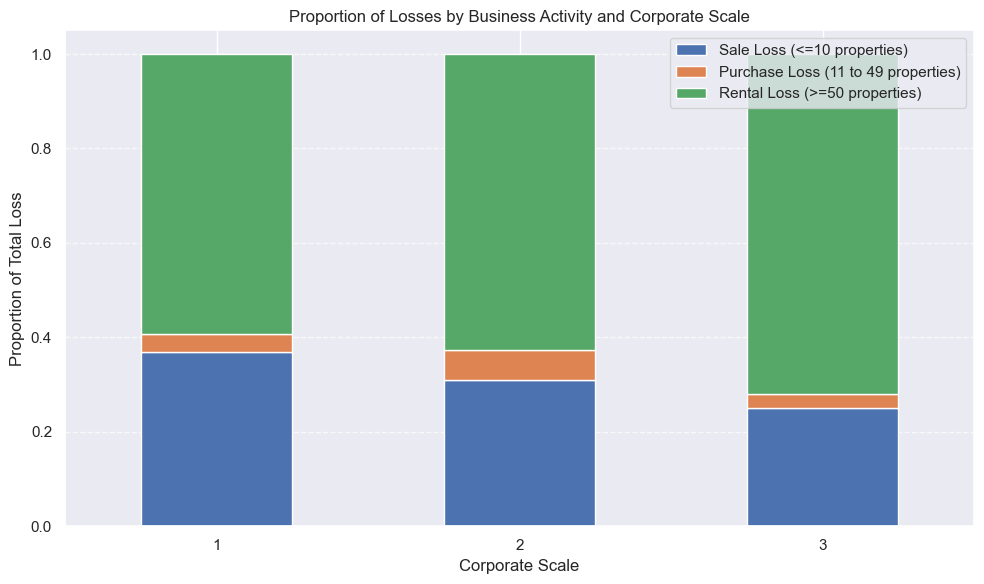

In [70]:
ax = totals_by_scale[["corp_scale", "sale_loss_prop", "purchase_loss_prop", "rental_value_adj_prop"]].set_index("corp_scale").plot(
    kind='bar', 
    stacked=True,
    figsize=(10, 6)
)

ax.set_title('Proportion of Losses by Business Activity and Corporate Scale')
ax.set_xlabel('Corporate Scale')
ax.set_ylabel('Proportion of Total Loss')
ax.legend(['Sale Loss (<=10 properties)', 'Purchase Loss (11 to 49 properties)', 'Rental Loss (>=50 properties)'], loc='upper right')

plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# nbhd map, each activity, proportion of loss
frames = [
    corp_involved_sales[corp_involved_sales["corp_sold_ind"] == 1].rename(columns={"total_loss_adj": "sale_loss"}).groupby(["neighborhood"])["sale_loss"].sum(),
    corp_involved_sales[corp_involved_sales["corp_bought_ind"] == 1].rename(columns={"total_loss_adj": "purchase_loss"}).groupby(["neighborhood"])["purchase_loss"].sum(),
    rental_loss_digest.rename(columns={"owner scale": "corp_scale"}).groupby(["neighborhood"])["rental_value_adj"].sum()
]

frames = [frame.reset_index() for frame in frames]

nbhd_by_activity = reduce(lambda left, right: pd.merge(left, right, on=["neighborhood"], how='inner'), frames).reset_index()
nbhd_by_activity["total_adj"] = nbhd_by_activity["sale_loss"] + nbhd_by_activity["purchase_loss"] + nbhd_by_activity["rental_value_adj"]
nbhd_by_activity["sale_loss_prop"] = nbhd_by_activity["sale_loss"] / nbhd_by_activity["total_adj"]
nbhd_by_activity["purchase_loss_prop"] = nbhd_by_activity["purchase_loss"] / nbhd_by_activity["total_adj"]
nbhd_by_activity["rental_value_adj_prop"] = nbhd_by_activity["rental_value_adj"] / nbhd_by_activity["total_adj"]

nbhd_by_activity.head(3)

index                                       neighborhood        sale_loss  \
0       0                             Adair Park, Pittsburgh  9,223,782.16833   
1       1              Adams Park, Laurens Valley, Southwest  6,606,295.82456   
2       2                               Adamsville, Oakcliff  1,405,351.63299   
3       3                            Almond Park, Carey Park    547,710.22258   
4       4  Amal Heights, Betmar LaVilla, High Point, Joyland    727,417.43411   
5       5                       Ansley Park, Sherwood Forest  3,581,027.37812   
6       6  Arden/Habersham, Argonne Forest, Peachtree Bat...    770,465.11408   
7       7                                 Ardmore, Brookwood    835,301.65469   
8       8  Arlington Estates, Ben Hill, Butner/Tell, Elmc...    758,515.48976   
9       9  Ashley Courts, Greenbriar Village, Niskey Cove...  1,042,087.37725   
10     10            Ashview Heights, Harris Chiles, Just Us  2,152,959.80229   
11     11                     Atkins Park, Virginia Highland  7,185,278.05910   
12     12  Atlanta Industrial Park, Bolton Hills, Brookvi...    737,357.23204   
13     13  Atlanta University Center, The Villages at Cas...    580,571.89947   
14     14                   Atlantic Station, Loring Heights  1,028,683.68710   
15     15  Audobon Forest, Audobon Forest West, Chalet Wo...  4,700,720.40092   
16     16  Baker Hills, Bakers Ferry, Boulder Park, Fairb...  2,213,313.16246   
17     17  Bankhead Courts, Bankhead/Bolton, Carroll Heig...    181,102.57129   
18     18                          Bankhead, Washington Park  2,416,147.11063   
19     19   Beecher Hills, Florida Heights, Westwood Terrace  4,969,178.06827   
20     20  Ben Hill Acres, Briar Glen, Cascade Green, Her...  1,801,954.55157   
21     21  Ben Hill Forest, Ben Hill Pines, Brentwood, De...  1,435,332.33455   
22     22  Ben Hill Terrace, Kings Forest, Old Fairburn V...  1,146,990.34636   
23     23  Benteen Park, Boulevard Heights, Custer/McDono...  7,722,383.05385   
24     24               Berkeley Park, Blandtown, Hills Park 13,295,321.60934   
25     25  Blair Villa/Poole Creek, Glenrose Heights, Orc...  3,212,725.07133   
26     26           Bolton, Riverside, Whittier Mill Village  8,315,928.08877   
27     27  Brandon, Castlewood, Westminster/Milmar, Woodf...  3,693,086.23388   
28     28                                         Brookhaven  3,880,956.30060   
29     29                                    Brookwood Hills    486,736.73741   
30     30  Browns Mill Park, Polar Rock, Swallow Circle/B...  9,348,413.43036   
31     31                 Buckhead Forest, South Tuxedo Park  1,767,385.09804   
32     32            Buckhead Heights, Lenox, Ridgedale Park    391,084.75477   
33     33                   Buckhead Village, Peachtree Park  1,897,733.20771   
34     34                        Bush Mountain, Oakland City  5,307,414.35089   
35     35                          Cabbagetown, Reynoldstown 12,424,309.93358   
36     36         Campbellton Road, Fort Valley, Pomona Park  2,087,359.25425   
37     37                        Capitol Gateway, Summerhill  6,525,330.00473   
38     38                   Capitol View, Capitol View Manor  3,923,035.09244   
39     39  Carver Hills, Rockdale, Scotts Crossing, West ... 11,763,010.90373   
40     40                                Cascade Avenue/Road  5,549,761.60670   
41     41  Cascade Heights, East Ardley Road, Green Acres...  3,734,149.49011   
42     42                Center Hill, Harvel Homes Community  2,502,876.10061   
43     43  Channing Valley, Memorial Park, Springlake, Wi...  2,549,662.27248   
44     44                         Chastain Park, Tuxedo Park  6,021,648.17629   
45     45                    Chosewood Park, Englewood Manor  3,588,257.87451   
46     46                                    Collier Heights  6,245,782.90477   
47     47  Collier Hills, Collier Hills North, Colonial H...  1,849,083.46040   
48     48         Dixie Hills, Pene

In [ ]:
nbhd_by_activity = nbhd_by_activity.merge(nsa_geo[["neighborhood", "geometry"]], on="neighborhood", how="left")

In [ ]:
# nbhd map, share of total loss by scale
frames = [
    corp_involved_sales[corp_involved_sales["corp_sold_ind"] == 1].rename(columns={"total_loss_adj": "sale_loss"}).groupby(["neighborhood", "corp_scale"])["sale_loss"].sum(),
    corp_involved_sales[corp_involved_sales["corp_bought_ind"] == 1].rename(columns={"total_loss_adj": "purchase_loss"}).groupby(["neighborhood", "corp_scale"])["purchase_loss"].sum(),
    rental_loss_digest.groupby(["neighborhood", "corp_scale"])["rental_value_adj"].sum()
]

frames = [frame.reset_index() for frame in frames]

totals_by_scale = totals_by_scale.fillna(0)
totals_by_scale = reduce(lambda left, right: pd.merge(left, right, on=["neighborhood", "corp_scale"], how='outer'), frames).reset_index()
totals_by_scale = totals_by_scale.fillna(0)
totals_by_scale["total_adj"] = totals_by_scale["sale_loss"] + totals_by_scale["purchase_loss"] + totals_by_scale["rental_value_adj"]
totals_by_scale = totals_by_scale.merge(
    totals_by_scale.groupby("neighborhood")["total_adj"].sum().rename("total_across_all"),
    on="neighborhood",
    how="outer"
)
totals_by_scale["prop"] = totals_by_scale["total_adj"] / totals_by_scale["total_across_all"]
totals_by_scale = totals_by_scale.drop(columns=["index"])
totals_by_scale

neighborhood  corp_scale        sale_loss  \
0                   Adair Park, Pittsburgh           1  6,692,238.35776   
1                   Adair Park, Pittsburgh           2  1,781,598.42231   
2                   Adair Park, Pittsburgh           3    749,945.38826   
3    Adams Park, Laurens Valley, Southwest           1  5,536,969.49935   
4    Adams Park, Laurens Valley, Southwest           2  1,043,263.60793   
..                                     ...         ...              ...   
271                               West End           3    223,263.38824   
272                               Westview           1 11,522,098.99118   
273                               Westview           2  3,221,147.59056   
274                               Westview           3    188,724.62719   
275   Georgia Tech, Marietta Street Artery           1          0.00000   

      purchase_loss  rental_value_adj        total_adj  total_across_all  \
0   2,719,349.26334   9,786,287.43266 19,197,875.05377  30,962,927.21735   
1   1,106,620.14212   5,460,112.03158  8,348,330.59601  30,962,927.21735   
2     615,129.57187   2,051,646.60744  3,416,721.56757  30,962,927.21735   
3   1,738,140.33222   4,442,873.70133 11,717,983.53290  17,040,302.44196   
4     119,104.04277   1,843,923.80534  3,006,291.45604  17,040,302.44196   
..              ...               ...              ...               ...   
271   309,914.56434     992,076.57123  1,525,254.52381  25,952,705.76034   
272  -626,851.37713   5,424,482.09038 16,319,729.70444  25,218,610.16958   
273   398,018.05240   2,911,400.78443  6,530,566.42739  25,218,610.16958   
274   238,931.64448   1,940,657.76608  2,368,314.03775  25,218,610.16958   
275         0.00000     295,744.97600    295,744.97600     295,744.97600   

       prop  
0   0.62003  
1   0.26962  
2   0.11035  
3   0.68766  
4   0.17642  
..      ...  
271 0.05877  
272 0.64713  
273 0.25896  
274 0.09391  
275 1.00000  

[276 rows x 8 columns]

In [ ]:
totals_by_scale = totals_by_scale.merge(nsa_geo[["neighborhood", "geometry"]], on="neighborhood", how="left")

In [ ]:
totals_by_scale["prop"] = totals_by_scale["prop"].round(2)
totals_by_scale["prop"] = totals_by_scale["prop"].apply(lambda x: 1 if x > 1 else x)
totals_by_scale["prop"] = totals_by_scale["prop"].apply(lambda x: 0 if x < 0 else x)

In [ ]:
totals_by_scale[totals_by_scale["neighborhood"] == "Buckhead Village, Peachtree Park"] 

neighborhood  corp_scale       sale_loss  \
96  Buckhead Village, Peachtree Park           1 1,209,577.12687   
97  Buckhead Village, Peachtree Park           2   442,336.26349   
98  Buckhead Village, Peachtree Park           3   245,819.81736   

      purchase_loss  rental_value_adj       total_adj  total_across_all  \
96 -1,168,904.02614   6,262,252.36104 6,302,925.46177   6,860,733.10489   
97   -167,974.47209     365,635.24276   639,997.03416   6,860,733.10489   
98   -368,490.26484      40,481.05644   -82,189.39104   6,860,733.10489   

      prop                                           geometry  
96 0.92000  POLYGON ((-84.38034 33.83709, -84.37974 33.837...  
97 0.09000  POLYGON ((-84.38034 33.83709, -84.37974 33.837...  
98 0.00000  POLYGON ((-84.38034 33.83709, -84.37974 33.837...

<Axes: xlabel='TAXYR', ylabel='total_adj'>

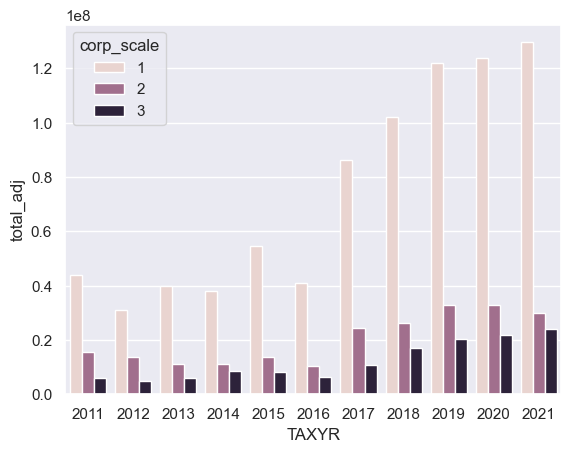

In [ ]:
sns.barplot(
    x="TAXYR",
    y="total_adj",
    hue="corp_scale",
    data=total_by_scale
)

In [ ]:
totals = pd.merge(
    left=corp_involved_sales[corp_involved_sales["corp_sold_ind"] == 1].groupby("TAXYR")["total_loss_adj"].sum(),
    right=corp_involved_sales[corp_involved_sales["corp_bought_ind"] == 1].groupby("TAXYR")["total_loss_adj"].sum(),
    on="TAXYR"
).rename(columns={"total_loss_adj_x": "sale_loss_adj", "total_loss_adj_y": "purchase_loss_adj"}).reset_index().merge(
    rental_loss_digest.groupby("TAXYR")["rental_value_adj"].sum(),
    on="TAXYR"
)
totals["total_loss_adj"] = totals["sale_loss_adj"] + totals["purchase_loss_adj"] + totals["rental_value_adj"]
totals.loc['Total'] = totals.sum()
totals

TAXYR     sale_loss_adj  purchase_loss_adj  rental_value_adj  \
0      2,011.00000  16,533,307.50022    6,509,283.94348  42,395,083.19743   
1      2,012.00000   7,509,438.08720    7,693,540.81704  34,765,047.21024   
2      2,013.00000  19,587,191.70332    3,374,055.29737  34,389,537.02788   
3      2,014.00000  22,210,490.40361   -5,199,797.13772  40,637,363.78931   
4      2,015.00000  40,251,143.44026   -7,568,658.45394  43,745,402.93778   
5      2,016.00000   5,151,281.63721    4,944,116.22279  47,712,943.48777   
6      2,017.00000  87,707,056.39802  -15,477,590.08282  49,002,754.64542   
7      2,018.00000  62,684,052.75706    6,720,564.37209  75,801,134.92745   
8      2,019.00000  48,941,911.89380   22,859,663.29420 103,466,792.45712   
9      2,020.00000  43,639,245.34415   14,236,797.57399 120,429,007.70386   
10     2,021.00000  47,284,705.94401   10,982,745.81293 125,264,971.73709   
Total 22,176.00000 401,499,825.10886   49,074,721.65941 717,610,039.12134   

           total_loss_adj  
0        65,437,674.64113  
1        49,968,026.11447  
2        57,350,784.02857  
3        57,648,057.05521  
4        76,427,887.92410  
5        57,808,341.34777  
6       121,232,220.96062  
7       145,205,752.05660  
8       175,268,367.64512  
9       178,305,050.62200  
10      183,532,423.49403  
Total 1,168,184,585.88962

In [ ]:
totals["Sale Year"] = totals["TAXYR"] - 1

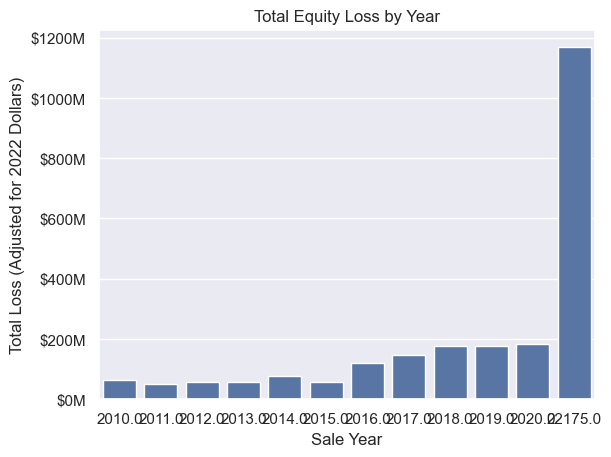

In [ ]:
import matplotlib.ticker as mticker

sns.barplot(
    x="Sale Year",
    y="total_loss_adj",
    data=totals
)

plt.title("Total Equity Loss by Year")

ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${int(round(x, -2)) // 1000000}M'))
plt.ylabel("Total Loss (Adjusted for 2022 Dollars)")
plt.show()

In [ ]:
only_corp_buyer = corp_involved_sales[corp_involved_sales["corp_bought_ind"] == 1]
only_corp_seller = corp_involved_sales[corp_involved_sales["corp_sold_ind"] == 1]

agg_buyer = only_corp_buyer.groupby(["TAXYR", "Buyer Scale"])[["sale_loss_adj", "purchase_loss_adj", "total_loss_adj"]].sum().reset_index().merge(
    only_corp_buyer.groupby(["TAXYR", "Buyer Scale"])["PARID"].count().reset_index().rename(columns={"PARID": "count"})
)
agg_seller = only_corp_seller.groupby(["TAXYR", "Seller Scale"])[["sale_loss_adj", "purchase_loss_adj", "total_loss_adj"]].sum().reset_index().merge(
    only_corp_seller.groupby(["TAXYR", "Seller Scale"])["PARID"].count().reset_index().rename(columns={"PARID": "count"})
)

agg_rental = rental_loss_digest.groupby(["TAXYR", "owner scale"])[["rental_value_adj"]].sum().reset_index().merge(
    rental_loss_digest.groupby(["TAXYR", "owner scale"])["PARID"].count().reset_index().rename(columns={"PARID": "count"})
)

In [ ]:
rental_loss_digest.groupby("owner scale")["rental_value_adj"].sum()

owner scale
1   524,014,601.01288
2   121,845,144.12287
3    71,750,293.98559
Name: rental_value_adj, dtype: float64

In [ ]:
corp_involved_sales.groupby("corp_scale")["total_loss_adj"].sum()

corp_scale
1   330,353,824.50325
2    82,619,841.47472
3    37,600,880.79031
Name: total_loss_adj, dtype: float64

In [ ]:
large_investor_loss_nbhd = corp_involved_sales[corp_involved_sales["corp_scale"] == 3].groupby(["neighborhood"])["total_loss_adj"].sum().reset_index()
large_investor_loss_nbhd["total_loss_adj"] = large_investor_loss_nbhd["total_loss_adj"].astype("float")
large_investor_loss_nbhd = large_investor_loss_nbhd.sort_values("total_loss_adj", ascending=False)

large_investor_loss_nbhd = large_investor_loss_nbhd.merge(
    nsa_geo,
    on="neighborhood",
    how="left"
)

large_investor_loss_nbhd.head(5)

neighborhood   total_loss_adj  \
0               Berkeley Park, Blandtown, Hills Park 11,298,678.89943   
1  Carver Hills, Rockdale, Scotts Crossing, West ...  9,293,078.57010   
2           Bolton, Riverside, Whittier Mill Village  2,086,203.38669   
3                             Adair Park, Pittsburgh  1,365,074.96013   
4   Beecher Hills, Florida Heights, Westwood Terrace    816,192.50770   

  STATISTICA                                           geometry GEOID  \
0        D03  POLYGON ((-84.40828 33.78821, -84.40767 33.788...   D03   
1        G03  POLYGON ((-84.43239 33.78723, -84.43238 33.787...   G03   
2        D01  POLYGON ((-84.48014 33.81733, -84.48023 33.817...   D01   
3        V02  POLYGON ((-84.40535 33.74403, -84.40447 33.744...   V02   
4        I01  POLYGON ((-84.46667 33.75176, -84.46674 33.747...   I01   

   Median household income 2021  \
0                 106,212.00000   
1                  45,616.00000   
2                 118,322.00000   
3                  39,353.00000   
4                  45,194.00000   

   % Not Hispanic Black or African American alone 2021  
0                                           31.30000    
1                                           74.90000    
2                                           24.70000    
3                                           75.20000    
4                                           95.70000

In [ ]:
large_investor_loss_nbhd.head(3)[["neighborhood", "total_loss_adj"]]

neighborhood   total_loss_adj
0               Berkeley Park, Blandtown, Hills Park 11,298,678.89943
1  Carver Hills, Rockdale, Scotts Crossing, West ...  9,293,078.57010
2           Bolton, Riverside, Whittier Mill Village  2,086,203.38669

In [ ]:
large_investor_loss_nbhd.tail(3)[["neighborhood", "total_loss_adj"]]

neighborhood  total_loss_adj
79                                    Underwood Hills  -301,316.00723
80  Fernleaf, Hanover West, Ridgewood Heights, Wes...  -309,047.74555
81                            Almond Park, Carey Park  -348,852.96805

## Figure 7. Proportion and Total Wealth Loss in Atlanta Neighborhoods by Corporate Scale

c:\Users\Nick\Documents\code\equity-extraction\utils.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\equity-extraction\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getat

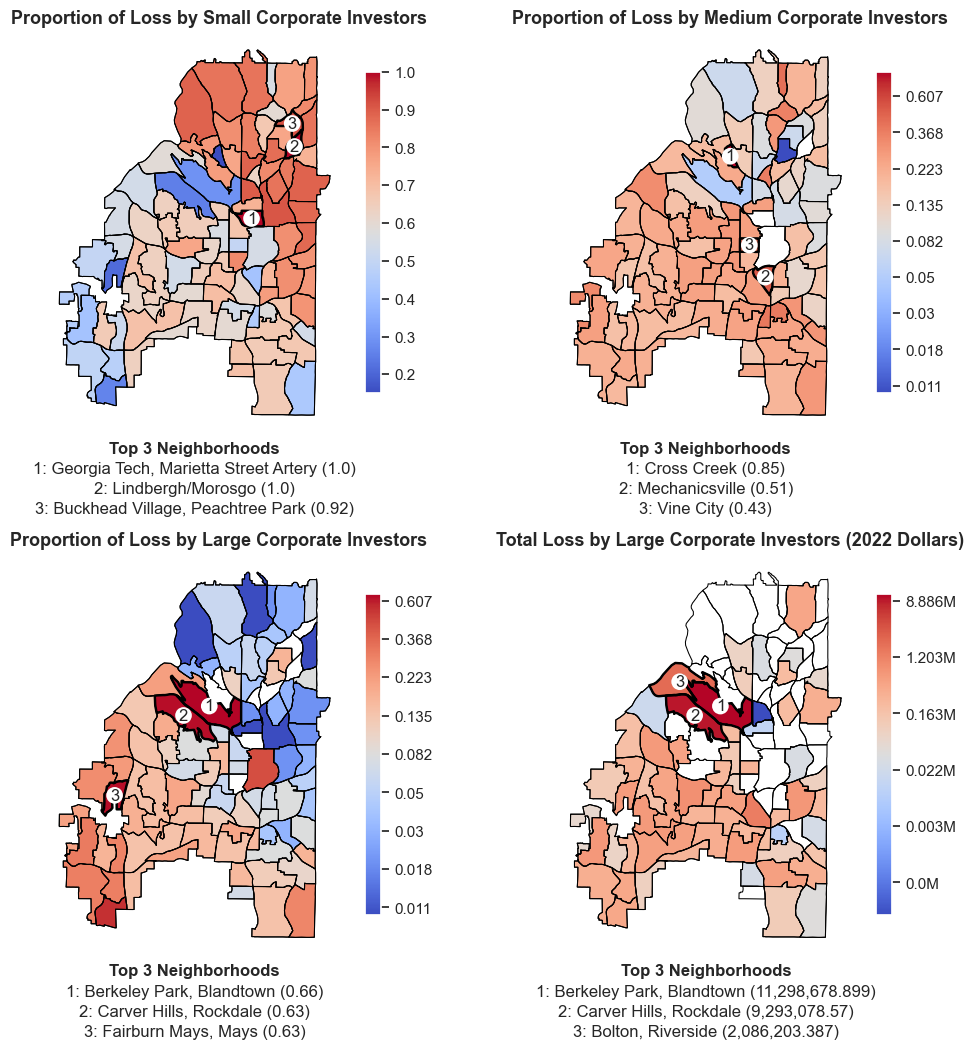

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'wspace': .22, 'hspace': .3})

#highlight = []

mapping = {
    1: "Small Corporate Investors",
    2: "Medium Corporate Investors",
    3: "Large Corporate Investors",
}
log_map = {
    0: False,
    1: True,
    2: True,
    3: True,
}
log=False
for i in range(0, 4):
    if i == 3:
        large_investor_loss_nbhd["total_loss_adj"] = large_investor_loss_nbhd["total_loss_adj"].astype("float")
        utils.map(
            large_investor_loss_nbhd[
                ~(large_investor_loss_nbhd["neighborhood"].str.contains("Downtown"))
            ],
            color="total_loss_adj",
            title="Total Loss by Large Corporate Investors (2022 Dollars)",
            nbhd_df=nsa_geo,
            ax=ax.flatten()[i],
            log=log_map[i],
            highlight="true",
        )
    else:
        temp_df = totals_by_scale[(totals_by_scale["corp_scale"] == (i+1))]
        if i == 1:
            temp_df = totals_by_scale[(totals_by_scale["corp_scale"] == (i+1))]
        utils.map(
            temp_df,
            color="prop",
            title=f"Proportion of Loss by {mapping[i+1]}",
            nbhd_df=nsa_geo,
            ax=ax.flatten()[i],
            log=log_map[i],
            highlight=highlight[i], #NA
        )

In [ ]:
rental_loss_digest.groupby(["owner scale", "neighborhood"])["rental_value_adj"].sum().reset_index().sort_values("rental_value_adj", ascending=True).head(5)

owner scale                                       neighborhood  \
216            3                   Buckhead Village, Peachtree Park   
198            3  Atlanta University Center, The Villages at Cas...   
228            3                         Chastain Park, Tuxedo Park   
109            2                   Atlantic Station, Loring Heights   
136            2                         Castleberry Hill, Downtown   

     rental_value_adj  
216      10,844.89880  
198      15,477.42550  
228      21,259.15594  
109      30,281.37854  
136      31,291.20673

In [ ]:
(rental_loss_digest.groupby(["owner scale", "neighborhood"])["rental_value_adj"].sum() / rental_loss_digest.groupby(["owner scale", "neighborhood"])["rental_value_adj"].count()).sort_values(ascending=False).head(5)

owner scale  neighborhood                                                                                                 
3            Buckhead Forest, South Tuxedo Park                                                                              136,357.97902
1            Kingswood, Mt. Paran/Northside, Mt. Paran Parkway, Randall Mill, West Paces Ferry/Northside, Whitewater Creek   124,714.27375
             Chastain Park, Tuxedo Park                                                                                      120,764.04873
             Margaret Mitchell, Paces, Pleasant Hill                                                                         117,925.36022
             Arden/Habersham, Argonne Forest, Peachtree Battle Alliance, Wyngate                                             113,200.39944
Name: rental_value_adj, dtype: float64

In [ ]:
corp_involved_sales.groupby(["corp_scale", "neighborhood"])["total_loss_adj"].sum() / corp_involved_sales.groupby(["corp_scale", "neighborhood"])["total_loss_adj"].count()

corp_scale  neighborhood                                     
1           Adair Park, Pittsburgh                               17,824.97656
            Adams Park, Laurens Valley, Southwest                35,662.30310
            Adamsville, Oakcliff                                 16,455.79651
            Almond Park, Carey Park                              11,337.88754
            Amal Heights, Betmar LaVilla, High Point, Joyland     8,511.94357
                                                                     ...     
3           Thomasville Heights                                   8,941.97689
            Underwood Hills                                     -75,329.00181
            Vine City                                            31,628.86951
            West End                                             20,506.84433
            Westview                                             11,254.11241
Name: total_loss_adj, Length: 267, dtype: float64

In [ ]:
corp_involved_sales.groupby("corp_scale")["total_loss_adj"].sum() / corp_involved_sales.groupby("corp_scale")["total_loss_adj"].count()

corp_scale
1   29,775.01798
2   26,362.42549
3   17,240.20210
Name: total_loss_adj, dtype: float64

In [ ]:
agg_buyer.groupby("Buyer Scale")["total_loss_adj"].sum()

Buyer Scale
1   31,662,540.59408
2   14,688,443.56000
3    2,723,737.50533
Name: total_loss_adj, dtype: float64

In [ ]:
agg_buyer.groupby("Buyer Scale")["total_loss_adj"].sum() / agg_buyer.groupby("Buyer Scale")["count"].sum()

Buyer Scale
1    6,298.49624
2   17,424.01371
3    5,895.53573
dtype: float64

In [ ]:
agg_seller.groupby("Seller Scale")["total_loss_adj"].sum()

Seller Scale
1   325,128,937.85389
2    58,795,125.34828
3    17,575,761.90670
Name: total_loss_adj, dtype: float64

In [ ]:
agg_seller.groupby("Seller Scale")["total_loss_adj"].sum() / agg_seller.groupby("Seller Scale")["count"].sum()

Seller Scale
1   42,445.03105
2   34,143.51066
3   25,252.53148
dtype: float64

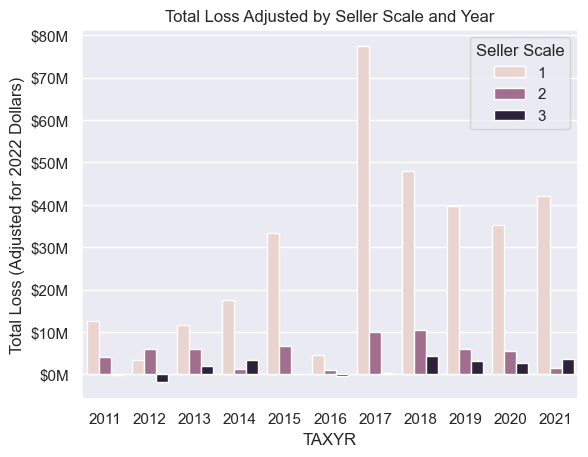

In [ ]:
sns.barplot(
    x="TAXYR",
    y="total_loss_adj",
    hue="Seller Scale",
    data=agg_seller
)

plt.title("Total Loss Adjusted by Seller Scale and Year")

ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${int(round(x, -2)) // 1000000}M'))
plt.ylabel("Total Loss (Adjusted for 2022 Dollars)")
plt.show()

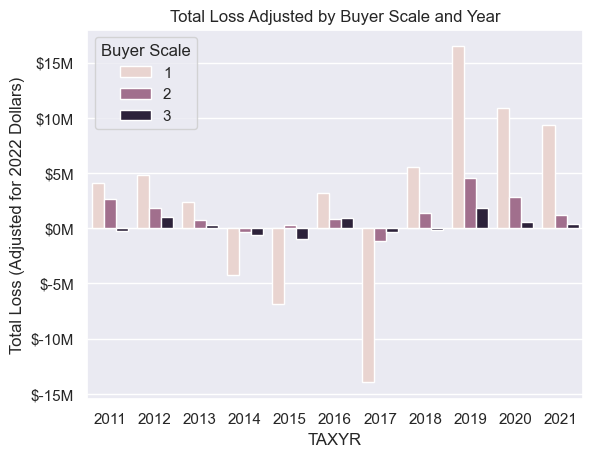

In [ ]:
sns.barplot(
    x="TAXYR",
    y="total_loss_adj",
    hue="Buyer Scale",
    data=agg_buyer
)

plt.title("Total Loss Adjusted by Buyer Scale and Year")

ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${int(round(x, -2)) // 1000000}M'))
plt.ylabel("Total Loss (Adjusted for 2022 Dollars)")
plt.show()

## Figure 5. Corporate SFR Business-Driven Wealth Loss of Atlanta Neighborhoods

c:\Users\Nick\Documents\code\equity-extraction\utils.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

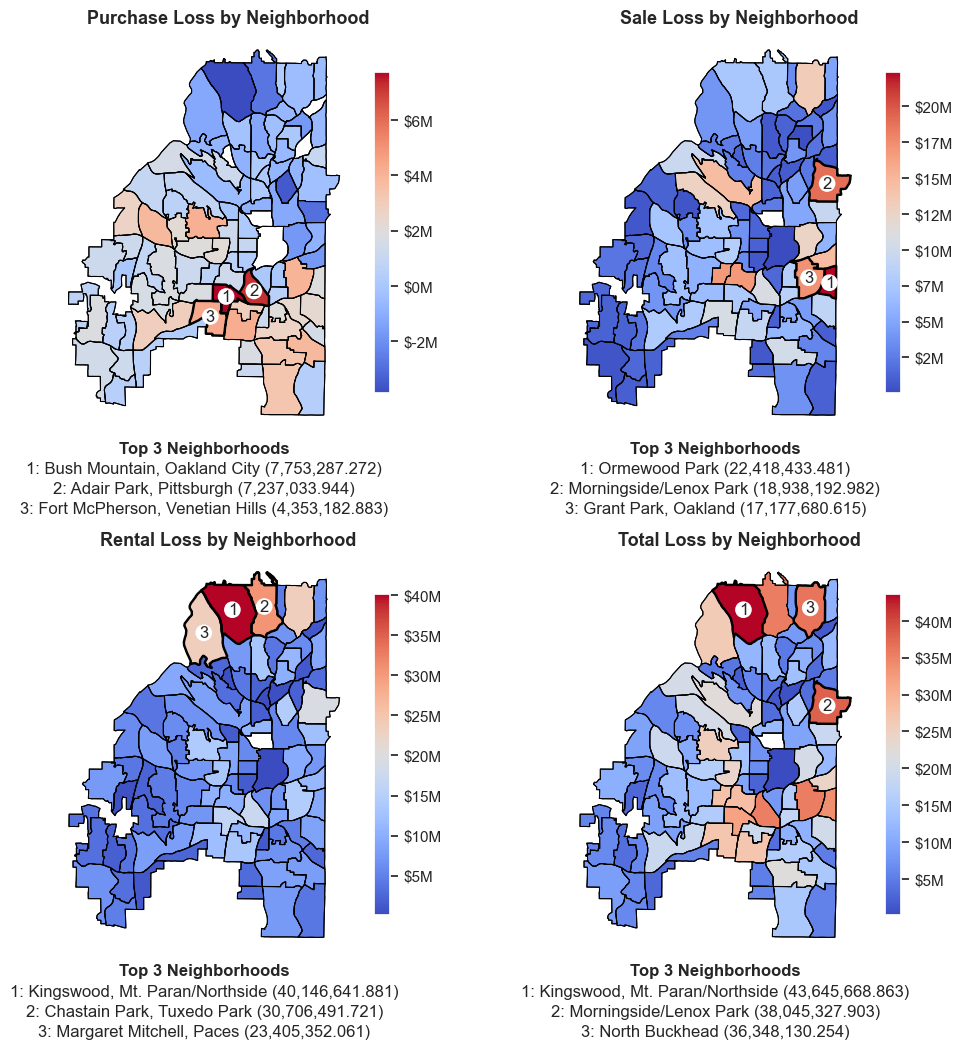

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'wspace': .22, 'hspace': .3})

names = {
    "sale_loss_adj": "Sale",
    "purchase_loss_adj": "Purchase",
    "rental_loss_adj": "Rental",
    "total_loss_adj": "Total"
}

j = 0
i = 0

highlight = [
    [
        "Bush Moutain, Oakland City",
        "Adair Park, Pittsburgh",
        "Sylvan Hills"
    ],
    [
        "Morningside/Lenox Park",
        "Ormewood Park",
        "Grant Park, Oakland"
    ],
    [
        "Kingswood, Mt. Paran/Northside, Mt. Paran Parkway, Randall Mill, West Paces Ferry/Northside, Whitewater Creek",
        "Chastain Park, Tuxedo Park",
    ],
    [
        "Kingswood, Mt. Paran/Northside, Mt. Paran Parkway, Randall Mill, West Paces Ferry/Northside, Whitewater Creek",
        "Chastain Park, Tuxedo Park",
        "Ormewood Park",
        "Grant Park, Oakland",
        "Adair Park, Pittsburgh",
    ]
]

h = 0
for color in ["purchase_loss_adj", "sale_loss_adj", "rental_loss_adj", "total_loss_adj"]:
    utils.map(
        total_equity,
        color=color,
        title=f"{names[color]} Loss by Neighborhood",
        nbhd_df=nsa_geo,
        ax=ax[i][j],
        format_func=format_millions,
        highlight=highlight[h],
    )
    h += 1
    j += 1
    if j == 2:
        j = 0
        i += 1


## Figure 8. Relative Wealth Loss of Atlanta Neighborhoods

In [ ]:
per_year_nsa = pd.read_csv("data/atl_nsa_by_year.csv").rename(
    columns={
        "tAggregateHHInc_e": "income_generated"
    }
)
per_year_nsa["NSA"] = per_year_nsa["NSA"].astype(str)
per_year_nsa["Year"] = per_year_nsa["Year"].astype(int)
equity_summary["GEOID"] = equity_summary["GEOID"].astype(str)
per_year_nsa["income_generated"] = per_year_nsa.groupby("NSA")["income_generated"].ffill()
per_year_nsa.head(2)

NSA  Year  income_generated  tAggregateHHInc_m  TotalHH_e  TotalHH_m  \
0  A01  2012 411,688,128.00000   59,720,255.00000       1891        135   
1  A02  2012 502,266,950.00000   94,246,239.00000       1668        154   

   aMeanHHIncome_e  aMeanHHIncome_m  
0    217,722.28000     27,470.20000  
1    301,173.06000     49,209.79000

In [ ]:
equity_summary = equity_summary.merge(
    per_year_nsa,
    left_on=["GEOID", "TAXYR"],
    right_on=["NSA", "Year"],
)

In [ ]:
equity_summary.groupby("neighborhood")["total_loss"].sum().sort_values(ascending=False).head(3)

neighborhood
Kingswood, Mt. Paran/Northside, Mt. Paran Parkway, Randall Mill, West Paces Ferry/Northside, Whitewater Creek   33,063,646.20000
Morningside/Lenox Park                                                                                          29,945,275.80000
North Buckhead                                                                                                  27,413,288.80000
Name: total_loss, dtype: float64

In [ ]:
equity_summary["equity_burden"] = equity_summary["total_loss"] / equity_summary["income_generated"]
equity_summary.sort_values(by="equity_burden", ascending=False).head(3)

TAXYR                     neighborhood   sale_loss_adj  \
632   2019      Bush Mountain, Oakland City   394,572.38661   
755   2020                 Lakewood Heights 1,932,387.84887   
554   2018  Chosewood Park, Englewood Manor   311,937.59107   

     purchase_loss_adj       sale_loss   purchase_loss  rental_loss_adj  \
632    3,701,284.41513   333,998.00000 3,133,066.66667  3,287,599.69737   
755      247,291.56439 1,673,108.00000   214,111.00000  1,328,240.46831   
554    1,043,564.27609   259,100.00000   866,800.00000    874,113.01955   

        rental_loss  total_loss_adj      total_loss STATISTICA  \
632 2,846,483.10000 7,383,456.49911 6,313,547.76667        S01   
755 1,165,686.00000 3,507,919.88157 3,052,905.00000        Y04   
554   739,920.00000 2,229,614.88671 1,865,820.00000        Y01   

                                              geometry GEOID  \
632  POLYGON ((-84.42708 33.73314, -84.42715 33.733...   S01   
755  POLYGON ((-84.37990 33.71013, -84.38131 33.709...   Y04   
554  POLYGON ((-84.36420 33.71207, -84.36484 33.712...   Y01   

     Median household income 2021  \
632                  31,760.00000   
755                  45,657.00000   
554                  37,211.00000   

     % Not Hispanic Black or African American alone 2021  NSA  Year  \
632                                           88.80000    S01  2019   
755                                           88.90000    Y04  2020   
554                                           58.90000    Y01  2018   

     income_generated  tAggregateHHInc_m  TotalHH_e  TotalHH_m  \
632  58,932,868.00000    9,089,773.00000       1454        121   
755  35,493,306.00000   11,685,724.00000        690        144   
554  23,706,966.00000    5,843,273.00000        493         54   

     aMeanHHIncome_e  aMeanHHIncome_m  equity_burden  
632     40,523.97000      5,254.32000        0.10713  
755     51,408.15000     13,066.86000        0.08601  
554     48,042.66000     10,632.98000        0.07870

In [ ]:
loss = equity_summary.groupby("neighborhood")["total_loss"].sum()
income = equity_summary.groupby("neighborhood")["income_generated"].sum()

equity_burden = pd.concat([loss, income], axis=1).reset_index()
equity_burden["equity_burden"] = equity_burden["total_loss"] / equity_burden["income_generated"]
equity_burden = equity_burden.merge(
    nsa_geo,
    on="neighborhood",
    how="left"
)
equity_burden["equity_burden"] = equity_burden["equity_burden"].fillna(0)
equity_burden.sort_values(by="equity_burden", ascending=False).head(3)

neighborhood       total_loss  income_generated  \
34      Bush Mountain, Oakland City 23,573,229.90952 622,021,001.00000   
46  Chosewood Park, Englewood Manor  8,798,048.60000 245,249,444.00000   
93                         Westview 21,709,318.42000 664,671,647.00000   

    equity_burden STATISTICA  \
34        0.03790        S01   
46        0.03587        Y01   
93        0.03266        T03   

                                             geometry GEOID  \
34  POLYGON ((-84.42708 33.73314, -84.42715 33.733...   S01   
46  POLYGON ((-84.36420 33.71207, -84.36484 33.712...   Y01   
93  POLYGON ((-84.43288 33.73904, -84.43285 33.739...   T03   

    Median household income 2021  \
34                  31,760.00000   
46                  37,211.00000   
93                  47,106.00000   

    % Not Hispanic Black or African American alone 2021  
34                                           88.80000    
46                                           58.90000    
93                                           82.20000

In [ ]:
total_equity.sort_values(by="total_loss", ascending=False).head(3)

neighborhood    sale_loss_adj  \
65  Kingswood, Mt. Paran/Northside, Mt. Paran Park...  7,382,099.95390   
75                             Morningside/Lenox Park 18,938,192.98236   
0                              Adair Park, Pittsburgh 10,843,104.76218   

    purchase_loss_adj  rental_loss_adj        sale_loss    purchase_loss  \
65   -3,883,072.97139 40,146,641.88088  6,335,570.00000 -3,223,707.00000   
75     -301,090.64381 19,408,225.56397 15,475,847.00000   -295,877.00000   
0     7,237,033.94373 17,298,046.07168  9,188,729.89286  6,294,731.33333   

        rental_loss   total_loss_adj       total_loss STATISTICA  \
65 33,592,459.20000 43,645,668.86339 36,704,322.20000        A02   
75 16,254,778.80000 38,045,327.90251 31,434,748.80000        F04   
0  14,843,802.18000 35,378,184.77759 30,327,263.40619        V02   

                                             geometry GEOID  \
65  POLYGON ((-84.40725 33.84953, -84.40723 33.850...   A02   
75  POLYGON ((-84.33840 33.80105, -84.33803 33.802...   F04   
0   POLYGON ((-84.40535 33.74403, -84.40447 33.744...   V02   

    Median household income 2021  \
65                 154,720.00000   
75                 127,788.00000   
0                   39,353.00000   

    % Not Hispanic Black or African American alone 2021  \
65                                            8.70000     
75                                            4.90000     
0                                            75.20000     

    Average household size 2021  # Total households 2021  
65                      2.20000                     2019  
75                      2.20000                     4748  
0                       2.20000                     1930

c:\Users\Nick\Documents\code\equity-extraction\utils.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",


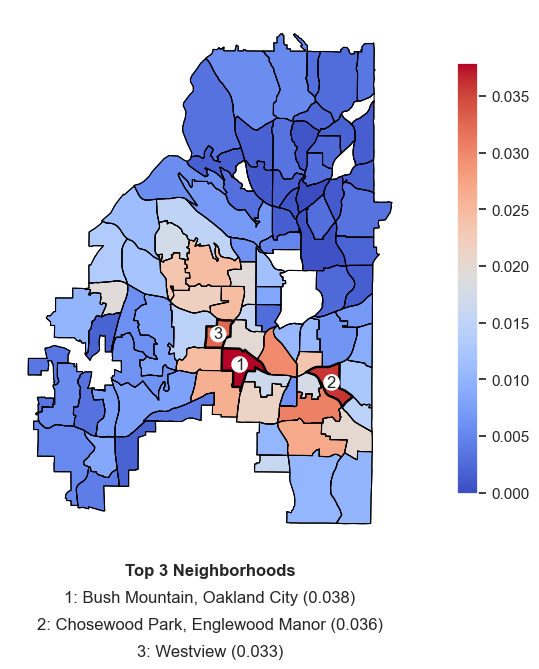

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

highlight = [
    'Chosewood Park, Englewood Manor',
    'Grove Park',
    'Browns Mill Park, Polar Rock, Swallow Circle/Baywood',
    'Bush Mountain, Oakland City',
]
utils.map(
    equity_burden,
    color="equity_burden",
    title="",
    nbhd_df=nsa_geo,
    ax=ax,
    highlight=highlight,
)

In [ ]:
equity_burden.sort_values("equity_burden", ascending=False).head(10)

neighborhood       total_loss  \
34                        Bush Mountain, Oakland City 23,573,229.90952   
46                    Chosewood Park, Englewood Manor  8,798,048.60000   
93                                           Westview 21,709,318.42000   
67                                   Lakewood Heights 11,367,764.40000   
0                              Adair Park, Pittsburgh 25,312,483.33952   
30  Browns Mill Park, Polar Rock, Swallow Circle/B... 16,541,553.96190   
55                     Fort McPherson, Venetian Hills 21,014,782.38095   
62                          Hunter Hills, Mozley Park 18,447,402.71333   
40                                Cascade Avenue/Road 11,561,196.00000   
59                                         Grove Park 17,739,278.04000   

    income_generated  equity_burden STATISTICA  \
34 622,021,001.00000        0.03790        S01   
46 245,249,444.00000        0.03587        Y01   
93 664,671,647.00000        0.03266        T03   
67 372,650,605.00000        0.03051        Y04   
0  848,029,600.00000        0.02985        V02   
30 618,144,437.00000        0.02676        Z04   
55 799,641,130.00000        0.02628        S02   
62 749,463,775.00000        0.02461        K01   
40 470,412,435.00000        0.02458        S03   
59 722,304,441.00000        0.02456        J02   

                                             geometry GEOID  \
34  POLYGON ((-84.42708 33.73314, -84.42715 33.733...   S01   
46  POLYGON ((-84.36420 33.71207, -84.36484 33.712...   Y01   
93  POLYGON ((-84.43288 33.73904, -84.43285 33.739...   T03   
67  POLYGON ((-84.37990 33.71013, -84.38131 33.709...   Y04   
0   POLYGON ((-84.40535 33.74403, -84.40447 33.744...   V02   
30  POLYGON ((-84.39870 33.68587, -84.39873 33.685...   Z04   
55  POLYGON ((-84.42606 33.71464, -84.42723 33.714...   S02   
62  POLYGON ((-84.43355 33.75590, -84.43420 33.755...   K01   
40  POLYGON ((-84.43991 33.72251, -84.43876 33.722...   S03   
59  POLYGON ((-84.45646 33.78600, -84.45656 33.785...   J02   

    Median household income 2021  \
34                  31,760.00000   
46                  37,211.00000   
93                  47,106.00000   
67                  45,657.00000   
0                   39,353.00000   
30                  31,158.00000   
55                  37,062.00000   
62                  33,621.00000   
40                  32,581.00000   
59                  26,358.00000   

    % Not Hispanic Black or African American alone 2021  
34                                           88.80000    
46                                           58.90000    
93                                           82.20000    
67                                           88.90000    
0                                            75.20000    
30                                           87.20000    
55                                           88.70000    
62                                           85.30000    
40                                           92.00000    
59                                           87.50000

In [ ]:
equity_burden["income_generated"].sum() - per_year_nsa[per_year_nsa["Year"] != 2012]["tAggregateHHInc_m"].sum()

143590479841.0

In [ ]:
equity_summary.sort_values("equity_burden", ascending=False).head(1)

TAXYR                 neighborhood  sale_loss_adj  purchase_loss_adj  \
632   2019  Bush Mountain, Oakland City  394,572.38661    3,701,284.41513   

        sale_loss   purchase_loss  rental_loss_adj     rental_loss  \
632 333,998.00000 3,133,066.66667  3,287,599.69737 2,846,483.10000   

     total_loss_adj      total_loss STATISTICA  \
632 7,383,456.49911 6,313,547.76667        S01   

                                              geometry GEOID  \
632  POLYGON ((-84.42708 33.73314, -84.42715 33.733...   S01   

     Median household income 2021  \
632                  31,760.00000   

     % Not Hispanic Black or African American alone 2021  NSA  Year  \
632                                           88.80000    S01  2019   

     income_generated  tAggregateHHInc_m  TotalHH_e  TotalHH_m  \
632  58,932,868.00000    9,089,773.00000       1454        121   

     aMeanHHIncome_e  aMeanHHIncome_m  equity_burden  
632     40,523.97000      5,254.32000        0.10713

In [ ]:
total_equity.agg({"sale_loss": sum, "purchase_loss": sum, "rental_loss": sum, "total_loss": sum})

C:\Users\Nick\AppData\Local\Temp\ipykernel_4028\672493611.py:1: FutureWarning: The provided callable <built-in function sum> is currently using Series.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_equity.agg({"sale_loss": sum, "purchase_loss": sum, "rental_loss": sum, "total_loss": sum})


sale_loss         393,693,325.57143
purchase_loss      66,534,302.00000
rental_loss       595,549,428.12000
total_loss      1,055,777,055.69143
dtype: float64

In [ ]:
sales["Sale Year"].value_counts()

Sale Year
2021    16789
2018    15909
2019    15460
2017    15408
2020    15237
2015    12899
2016    12085
2013    10385
2014    10251
2012     9381
2010     6950
2011     6524
Name: count, dtype: int64

In [ ]:
sales[sales["Sale Year"] == 2021].sample(3)

TAXYR            PARID  Luc       Saledt   SALES PRICE  \
61363   2022  14 008600091445  101  01-DEC-2021 330,000.00000   
62792   2022  14 005300100708  101  26-FEB-2021 330,000.00000   
48271   2022  12 264806810070  101  10-SEP-2021 580,000.00000   

       FAIR MARKET VALUE DEED TYPE  Costval Saleval  \
61363      330,000.00000        LW  342,000       0   
62792      330,000.00000        LW  334,500       0   
48271      580,000.00000        LW  648,800       0   

                                        GRANTOR  \
61363                              BENITO RANDY   
62792  RACHEL R QUARTARONE AND RICHARD M QUARTA   
48271        JASON R MANGES AND JAMIE L BALTRUS   

                             GRANTEE  M_flag  sale_size   sales_price  \
61363  NO LIMIT INVESTMENT GROUP LLC   False          1 330,000.00000   
62792                THOMAS MARIANNA   False          1 330,000.00000   
48271             CARRILLO GONZALO &   False          1 580,000.00000   

          price_adj       fmv_adj  count_sales_yr  \
61363 351,299.52439 351,299.52439               1   
62792 351,299.52439 351,299.52439               1   
48271 617,435.52772 617,435.52772               1   

                       GRANTEE_exact     GRANTEE_exact_addr  \
61363  NO LIMIT INVESTMENT GROUP LLC   265 FERN CREST 30046   
62792                THOMAS MARIANNA        591 TERRY 30312   
48271             CARRILLO GONZALO &  160 OLD ALABAMA 30076   

                 GRANTEE_single_sale GRANTEE_single_sale_addr  \
61363  NO LIMIT INVESTMENT GROUP LLC     265 FERN CREST 30046   
62792                THOMAS MARIANNA          591 TERRY 30312   
48271             CARRILLO GONZALO &    160 OLD ALABAMA 30076   

             GRANTEE_only_exact_name GRANTEE_only_exact_name_addr  \
61363  NO LIMIT INVESTMENT GROUP LLC         265 FERN CREST 30046   
62792                THOMAS MARIANNA              591 TERRY 30312   
48271             CARRILLO GONZALO &        160 OLD ALABAMA 30076   

      GRANTOR_exact GRANTOR_exact_addr     GRANTOR_single_sale  \
61363  BENITO RANDY    896 WELCH 30310            BENITO RANDY   
62792          <NA>               <NA>  QUARTARONE RICHARD M &   
48271          <NA>               <NA>        MANGES JASON R &   

      GRANTOR_single_sale_addr GRANTOR_only_exact_name  \
61363          896 WELCH 30310            BENITO RANDY   
62792          591 TERRY 30312                    <NA>   
48271    160 OLD ALABAMA 30076                    <NA>   

      GRANTOR_only_exact_name_addr                  GRANTEE_match  \
61363              896 WELCH 30310  NO LIMIT INVESTMENT GROUP LLC   
62792                         <NA>                THOMAS MARIANNA   
48271                         <NA>             CARRILLO GONZALO &   

          GRANTEE_match_addr           GRANTOR_match     GRANTOR_match_addr  \
61363   265 FERN CREST 30046            BENITO RANDY        896 WELCH 30310   
62792        591 TERRY 30312  QUARTARONE RICHARD M &        591 TERRY 30312   
48271  160 OLD ALABAMA 30076        MANGES JASON R &  160 OLD ALABAMA 30076   

       GRANTEE_corp_flag  GRANTOR_corp_flag  corp_bought_ind  corp_sold_ind  \
61363                  1                  0                1              0   
62792                  0                  0                0              0   
48271                  0                  0                0              0   

       ind_to_ind  corp_to_corp  Sale Year      OBJECTID  \
61363           0             0       2021 307,294.00000   
62792           1             0       2021 298,318.00000   
48271           1             0       2021  76,361.00000   

                                                geometry  index_right  \
61363  POLYGON ((-84.404452814579 33.7305055008452, -...     42.00000   
62792  POLYGON ((-84.3851910688385 33.7385639710821, ...     45.00000   
48271  POLYGON ((-84.2995946681325 34.0237383028148, ...          NaN   

                      neighborhood  Buyer Transactions Fulton  \
61363       Ada

In [ ]:
digest["TAXYR"].value_counts()

TAXYR
2022    220258
2021    219326
2020    217546
2019    215518
2018    213724
2017    212214
2015    209191
2014    207922
2013    207029
2012    205820
2011    205632
2010    205575
2016    199541
Name: count, dtype: int64

In [ ]:
total_equity["mb_flag"] = total_equity["neighborhood"].apply(lambda x: 1 if x in mb_neighborhoods else 0)

In [ ]:
total_equity.groupby("mb_flag")["total_loss_adj"].sum()

mb_flag
0   568,017,383.21933
1   681,492,035.17106
Name: total_loss_adj, dtype: float64

Average equity burden for mb and non-mb neighborhoods (sum mb generation, mb generation)

In [ ]:
equity_burden["mb_flag"] = equity_burden["neighborhood"].apply(lambda x: 1 if x in mb_neighborhoods else 0)

In [ ]:
equity_burden.groupby("mb_flag")["income_generated"].sum() * (digest["TAXYR"].nunique() - 1)

mb_flag
0   1,733,382,506,796.00000
1     453,857,804,688.00000
Name: income_generated, dtype: float64

In [ ]:
equity_burden.groupby("mb_flag")["total_loss"].sum() / equity_burden.groupby("mb_flag")["income_generated"].sum() * 100

mb_flag
0   0.28452
1   1.33930
dtype: float64

In [ ]:
equity_summary.sort_values("equity_burden", ascending=False).head(3)

TAXYR                     neighborhood   sale_loss_adj  \
632   2019      Bush Mountain, Oakland City   394,572.38661   
755   2020                 Lakewood Heights 1,932,387.84887   
554   2018  Chosewood Park, Englewood Manor   311,937.59107   

     purchase_loss_adj       sale_loss   purchase_loss  rental_loss_adj  \
632    3,701,284.41513   333,998.00000 3,133,066.66667  3,287,599.69737   
755      247,291.56439 1,673,108.00000   214,111.00000  1,328,240.46831   
554    1,043,564.27609   259,100.00000   866,800.00000    874,113.01955   

        rental_loss  total_loss_adj      total_loss STATISTICA  \
632 2,846,483.10000 7,383,456.49911 6,313,547.76667        S01   
755 1,165,686.00000 3,507,919.88157 3,052,905.00000        Y04   
554   739,920.00000 2,229,614.88671 1,865,820.00000        Y01   

                                              geometry GEOID  \
632  POLYGON ((-84.42708 33.73314, -84.42715 33.733...   S01   
755  POLYGON ((-84.37990 33.71013, -84.38131 33.709...   Y04   
554  POLYGON ((-84.36420 33.71207, -84.36484 33.712...   Y01   

     Median household income 2021  \
632                  31,760.00000   
755                  45,657.00000   
554                  37,211.00000   

     % Not Hispanic Black or African American alone 2021  NSA  Year  \
632                                           88.80000    S01  2019   
755                                           88.90000    Y04  2020   
554                                           58.90000    Y01  2018   

     income_generated  tAggregateHHInc_m  TotalHH_e  TotalHH_m  \
632  58,932,868.00000    9,089,773.00000       1454        121   
755  35,493,306.00000   11,685,724.00000        690        144   
554  23,706,966.00000    5,843,273.00000        493         54   

     aMeanHHIncome_e  aMeanHHIncome_m  equity_burden  
632     40,523.97000      5,254.32000        0.10713  
755     51,408.15000     13,066.86000        0.08601  
554     48,042.66000     10,632.98000        0.07870

In [ ]:
interest = [
    "Thomasville Heights",
    "South Atlanta, The Villages at Carver",
    "Adair Park, Pittsburgh",
    "Sylvan Hills"
]

In [ ]:
total_equity[total_equity["neighborhood"].isin(interest)].sort_values("total_loss_adj", ascending=False)

neighborhood    sale_loss_adj  purchase_loss_adj  \
0                  Adair Park, Pittsburgh 10,843,104.76218    7,237,033.94373   
88                           Sylvan Hills  9,313,723.74516    4,249,242.05086   
86  South Atlanta, The Villages at Carver  4,954,855.00240    2,009,740.54367   
89                    Thomasville Heights    967,014.27351    1,523,174.06954   

    rental_loss_adj       sale_loss   purchase_loss      rental_loss  \
0  17,298,046.07168 9,188,729.89286 6,294,731.33333 14,843,802.18000   
88 13,395,304.39278 7,770,575.00000 3,736,518.00000 11,534,171.40000   
86  4,157,694.05208 4,053,251.64286 1,622,698.66667  3,530,359.80000   
89  2,616,761.15521   835,246.00000 1,301,814.14286  2,264,275.20000   

     total_loss_adj       total_loss STATISTICA  \
0  35,378,184.77759 30,327,263.40619        V02   
88 26,958,270.18880 23,041,264.40000        X04   
86 11,122,289.59815  9,206,310.10952        Y03   
89  5,106,949.49826  4,401,335.34286        Z02   

                                             geometry GEOID  \
0   POLYGON ((-84.40535 33.74403, -84.40447 33.744...   V02   
88  POLYGON ((-84.41099 33.70963, -84.41135 33.709...   X04   
86  POLYGON ((-84.38012 33.71103, -84.38035 33.711...   Y03   
89  POLYGON ((-84.36203 33.70877, -84.36462 33.707...   Z02   

    Median household income 2021  \
0                   39,353.00000   
88                  44,466.00000   
86                  26,479.00000   
89                  18,812.00000   

    % Not Hispanic Black or African American alone 2021  \
0                                            75.20000     
88                                           73.00000     
86                                           90.70000     
89                                           92.10000     

    Average household size 2021  # Total households 2021  mb_flag  
0                       2.20000                     1930        1  
88                      2.30000                     1778        1  
86                      2.10000                     1275        1  
89                      3.30000                      891        1

In [ ]:
equity_burden[equity_burden["neighborhood"].isin(interest)].sort_values("equity_burden", ascending=False)

neighborhood       total_loss  income_generated  \
0                  Adair Park, Pittsburgh 25,312,483.33952 848,029,600.00000   
88                           Sylvan Hills 20,649,495.40000 971,761,680.00000   
86  South Atlanta, The Villages at Carver  8,590,466.10952 485,975,089.00000   
89                    Thomasville Heights  3,845,104.34286 264,363,674.00000   

    equity_burden STATISTICA  \
0         0.02985        V02   
88        0.02125        X04   
86        0.01768        Y03   
89        0.01454        Z02   

                                             geometry GEOID  \
0   POLYGON ((-84.40535 33.74403, -84.40447 33.744...   V02   
88  POLYGON ((-84.41099 33.70963, -84.41135 33.709...   X04   
86  POLYGON ((-84.38012 33.71103, -84.38035 33.711...   Y03   
89  POLYGON ((-84.36203 33.70877, -84.36462 33.707...   Z02   

    Median household income 2021  \
0                   39,353.00000   
88                  44,466.00000   
86                  26,479.00000   
89                  18,812.00000   

    % Not Hispanic Black or African American alone 2021  mb_flag  
0                                            75.20000          1  
88                                           73.00000          1  
86                                           90.70000          1  
89                                           92.10000          1

## Figure 8. Relative Wealth Loss of Atlanta Neighborhoods

c:\Users\Nick\Documents\code\equity-extraction\utils.py:436: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",


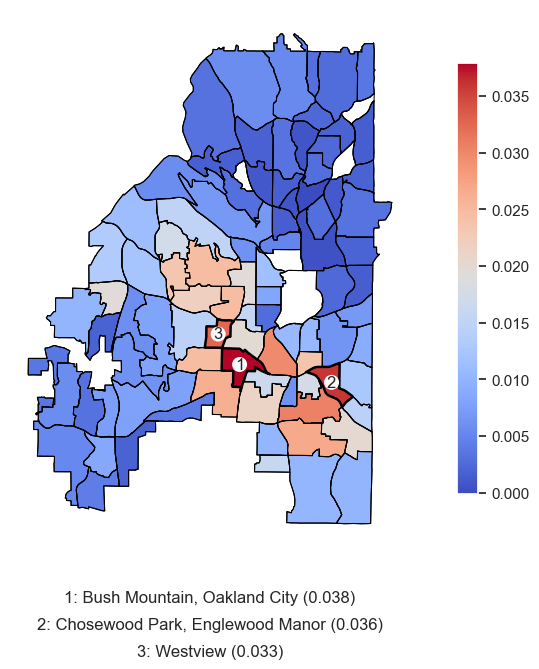

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

highlight = [
    'Chosewood Park, Englewood Manor',
    'Grove Park',
    'Browns Mill Park, Polar Rock, Swallow Circle/Baywood',
    'Bush Mountain, Oakland City',
]
utils.map_select(
    equity_burden,
    color="equity_burden",
    title="",
    nbhd_df=nsa_geo,
    ax=ax,
    highlight="true",
)

In [ ]:
equity_burden[equity_burden["neighborhood"].str.contains("Bush")]

neighborhood       total_loss  income_generated  \
34  Bush Mountain, Oakland City 23,573,229.90952 622,021,001.00000   

    equity_burden STATISTICA  \
34        0.03790        S01   

                                             geometry GEOID  \
34  POLYGON ((-84.42708 33.73314, -84.42715 33.733...   S01   

    Median household income 2021  \
34                  31,760.00000   

    % Not Hispanic Black or African American alone 2021  mb_flag  
34                                           88.80000          1

In [ ]:
# sum equity loss for each year by nbhd type
# sum household size * total households for each year by nbhd type
total_loss = equity_burden.groupby("mb_flag")["total_loss"].sum()
total_generation = equity_burden.groupby("mb_flag")["income_generated"].sum() * (digest["TAXYR"].nunique() - 1)

overall_pct = pd.concat([total_loss, total_generation], axis=1)
overall_pct["pct"] = overall_pct["total_loss"] / overall_pct["income_generated"] * 100
overall_pct

total_loss        income_generated     pct
mb_flag                                                  
0       410,982,779.30286 1,733,382,506,796.00000 0.02371
1       506,543,722.29429   453,857,804,688.00000 0.11161

---
## Statistical Tests: Corporate Power

NOTE: PLEASE REQUEST THIS SECTION FROM BRIAN AN; BELOW WAS ROUGH DRAFT VERSION AND DATA CLEANING

**Motivating question:** is the price paid (and sale_diff) different by sale type?

sale_diff = fmv_adj - price_adj

sale_type = corp to ind, ind to corp, etc.

**Model type**: Mixed Linear Model

**Model characteristics**
- Groups: neighborhoods and sale year (need to drop first year to avoid dummy trap)
- Treatment: type of sale (also need to avoid dummy trap, reference param in statsmodels library should do this)
- Dependent vars: sales price (log), sales_diff
- Covariates: 
    - Fixed effect: whether sale is valid, num beds, num baths, sqft living area, year built, heat
    - Random effect: sale year as level 1, neighborhoods nested within as level 2 - ADD TO MODEL

**Notes**
- Allow slopes and intercepts to vary?
- add in taxyr dummy, omitting first year (0): need to drop first year
- num bath, num bed, amenities, lot size, AC or not
- cluster standard errors at nbhd level

**Steps (do separately for each DV)**
- **Run model**
- **Residuals vs fitted plot (entire model):** verify there are no patterns, should be randomly distributed around zero
- **Residuals for each predictor variable:** verify no patterns
- **Distribution of residuals (QQ plot):** verify normal
- **Distribution of random effects (QQ plot):** verify normal
- **Variance inflation factors of IVs:** verify none are above 5-10
- **Correlation matrix of IVs:** verify all below 0.8
- **Degrees of Freedom:**
- **Confidence Intervals:** verify CIs don't include 0

In [ ]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

Prepare data: cast all int/float, take log of sales price, create dummy column

In [ ]:
# Use heat, 4 = Central Air, 3 is forced air, 2 non central, 1 is none
# from understanding the PRC
sales_stat_vars = {
    "Sale Year": "int",
    "neighborhood": "string",
    "corp_sold_ind": "int",
    "corp_bought_ind": "int",
    "ind_to_ind": "int",
    "corp_to_corp": "int",
    "Saleval": "string",
    "sales_price": "float",
    "FAIR MARKET VALUE": "float",
    "price_adj": "float",
    "sale_diff": "float",
    "sqft_living": "float",
    "yr_built": "int",
    "beds": "int",
    "baths": "int",
    "acres": "float",
    "heat": "int",
    "D Effyr": "int",
    "Extwall": "int",
    "Style": "string",
    "Rmtot": "int",
    "D Grade": "string",
    "Bsmt": "int"
}
sale_type_names = [
    "ind_to_ind",
    "corp_to_corp",
    "corp_bought_ind",
    "corp_sold_ind",
]
sales_atl = sales[sales["neighborhood"].notna()]
sales_atl = sales_atl.merge(digest[
    ["TAXYR", "PARID", "yr_built", "sqft_living", "beds", "baths", "acres", "heat", "D Effyr", "Extwall", "Style", "Rmtot", "D Grade", "Bsmt"]
], on=["PARID", "TAXYR"], how="left")
#sales_for_stat = sales_atl[sales_stat_vars.keys()].copy()
sales_for_stat = sales_atl
init_len = len(sales_for_stat)
sales_for_stat = sales_for_stat.dropna(subset=sales_stat_vars.keys())
print(f"Dropped {init_len - len(sales_for_stat)} records due to missing values from digest merge")
sales_for_stat["sale_type"] = pd.from_dummies(sales_for_stat[sale_type_names])
sales_for_stat["valid_sale"] = sales_for_stat.apply(
    lambda x: x["Saleval"] == "0",
    axis=1
).astype(int)

sales_for_stat["sale_type"] = pd.from_dummies(sales_for_stat[sale_type_names])

for col, dtype in sales_stat_vars.items():
    sales_for_stat[col] = sales_for_stat[col].astype(dtype)

# natural log of sales price (adj for inflation)
sales_for_stat["price_adj_log"] = np.log(sales_for_stat["price_adj"])
sales_for_stat.rename(columns={"Sale Year": "sale_year"}, inplace=True)

# save data for validation
sales_for_stat.to_csv("output/sales_for_stat.csv", index=False)

Dropped 746 records due to missing values from digest merge


C:\Users\Nick\AppData\Local\Temp\ipykernel_4028\366597621.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_for_stat["sale_type"] = pd.from_dummies(sales_for_stat[sale_type_names])
C:\Users\Nick\AppData\Local\Temp\ipykernel_4028\366597621.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_for_stat["valid_sale"] = sales_for_stat.apply(
C:\Users\Nick\AppData\Local\Temp\ipykernel_4028\366597621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [ ]:
len(sales_for_stat)

53527

Data Check for Dist of sale_diff: fmv_adj - price_adj

In [ ]:
sales_for_stat["sale_diff"].describe()

count     53,527.00000
mean     -25,377.77549
std       69,922.98812
min     -430,400.00000
25%      -46,000.00000
50%       -4,500.00000
75%            0.00000
max      299,147.00000
Name: sale_diff, dtype: float64

Helper Functions

In [ ]:
def run_model(df, formula, groups, re_formula="1"):
    formula = formula
    model = smf.mixedlm(formula, df, groups=df[groups], re_formula=re_formula)
    return model.fit()

def verbose_output(result):
    print(result.summary())
    print(result.random_effects)
    print(result.cov_re)
    print(result.cov_params())
    
    # for name, coef in zip(mixed_lm_result.model.exog_names, mixed_lm_result.params):
    #     percent_change = (np.exp(coef) - 1) * 100
    #     print(f"{name}: {percent_change:.2f}%")
    
def model_residuals(result):
    fitted_vals = result.fittedvalues
    residuals = result.resid
    plt.scatter(fitted_vals, residuals)
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.show()
    
def predictor_residuals(df, result, predictor):
    residuals = result.resid
    plt.scatter(df[predictor], residuals)
    plt.xlabel(f'{predictor}')
    plt.ylabel('Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.show()
    
def dist_residuals(result):
    residuals = result.resid
    fig = sm.qqplot(residuals, stats.t, fit=True, line="45")
    plt.show()
    
def dist_random_effects(result):
    random_effects = result.random_effects
    # Flatten the array for plotting
    #re_flat = np.concatenate([re.flatten() for re in random_effects.values()])
    print(random_effects)
    fig = sm.qqplot(random_effects, stats.t, fit=True, line="45")
    plt.show()
    
def vif(df, predictors):
    pred = df[predictors]
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(pred.values, i) for i in range(pred.shape[1])]
    vif["features"] = pred.columns
    print(vif)
    
def corr_matrix(df, predictors):
    pred = df[predictors]
    corr_matrix = pred.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.show()

def run_diagnostics(df, result, predictors):
    model_residuals(result)
    
    for predictor in predictors:
        predictor_residuals(df, result, predictor)
        
    dist_residuals(result)
    #dist_random_effects(result)
    #dist_random_effects(result, predictors)
    vif(df, predictors)
    corr_matrix(df, predictors)

### Model - Sales Price

In [ ]:
formula = 'price_adj_log ~ C(sale_type, Treatment(reference="ind_to_ind")) + C(valid_sale) + beds + baths + sqft_living + yr_built + C(heat) + C(sale_year)'
result = run_model(df=sales_for_stat, formula=formula, groups="neighborhood")
verbose_output(result)

                                    Mixed Linear Model Regression Results
Model:                             MixedLM                  Dependent Variable:                  price_adj_log
No. Observations:                  53527                    Method:                              REML         
No. Groups:                        95                       Scale:                               0.3803       
Min. group size:                   1                        Log-Likelihood:                      -50479.9905  
Max. group size:                   1889                     Converged:                           Yes          
Mean group size:                   563.4                                                                      
--------------------------------------------------------------------------------------------------------------
                                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------

In [ ]:
sales_for_stat["price_adj_log"].describe()

count   53,527.00000
mean        12.28923
std          1.40142
min          6.76415
25%         11.38211
50%         12.53098
75%         13.34822
max         16.38880
Name: price_adj_log, dtype: float64

In [ ]:
for name, coef in zip(result.model.exog_names, result.params):
    percent_change = (np.exp(coef) - 1) * 100
    print(f"{name}: {percent_change:.2f}%")

Intercept: 154060.22%
C(sale_type, Treatment(reference="ind_to_ind"))[T.corp_bought_ind]: -34.02%
C(sale_type, Treatment(reference="ind_to_ind"))[T.corp_sold_ind]: 11.12%
C(sale_type, Treatment(reference="ind_to_ind"))[T.corp_to_corp]: -26.99%
C(valid_sale)[T.1]: 33.15%
C(heat)[T.2]: -16.39%
C(heat)[T.3]: -5.23%
C(heat)[T.4]: 18.55%
C(sale_year)[T.2011]: -4.70%
C(sale_year)[T.2012]: -10.35%
C(sale_year)[T.2013]: 4.48%
C(sale_year)[T.2014]: 17.77%
C(sale_year)[T.2015]: 47.45%
C(sale_year)[T.2016]: 51.26%
C(sale_year)[T.2017]: 89.78%
C(sale_year)[T.2018]: 142.73%
C(sale_year)[T.2019]: 154.42%
C(sale_year)[T.2020]: 175.34%
C(sale_year)[T.2021]: 212.89%
beds: 0.24%
baths: 11.72%
sqft_living: 0.02%
yr_built: 0.18%


Diagnostics

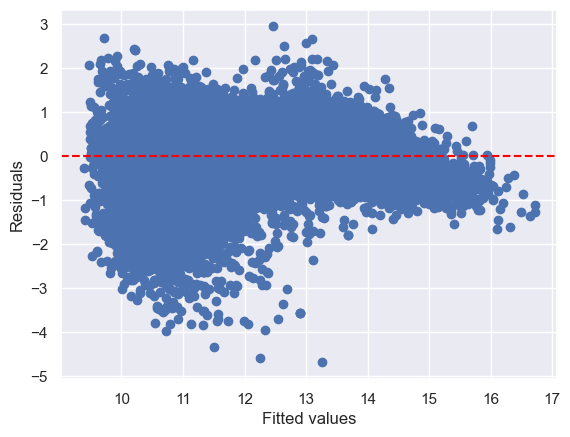

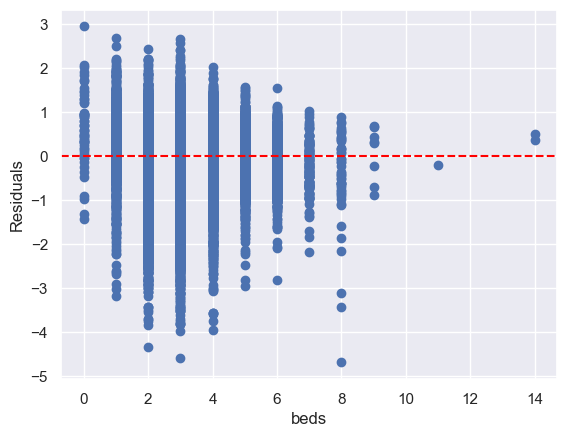

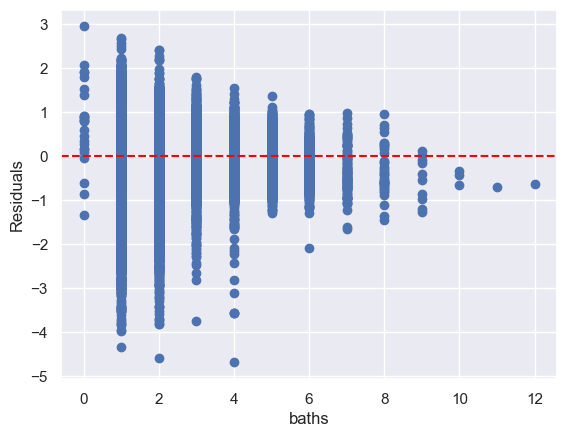

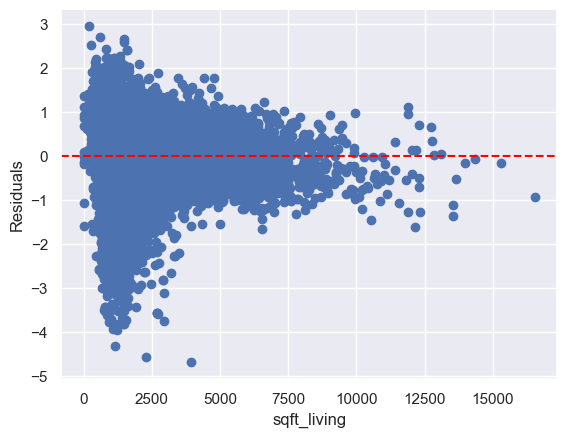

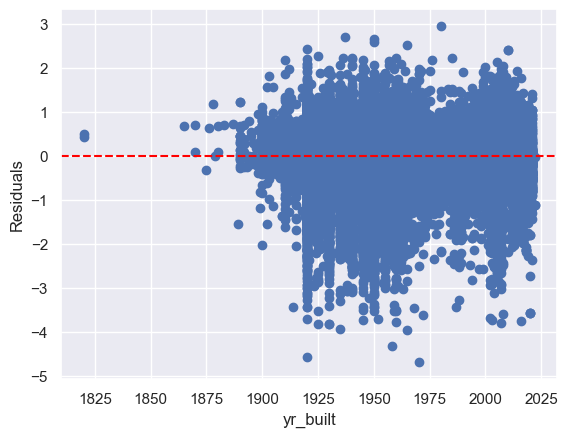

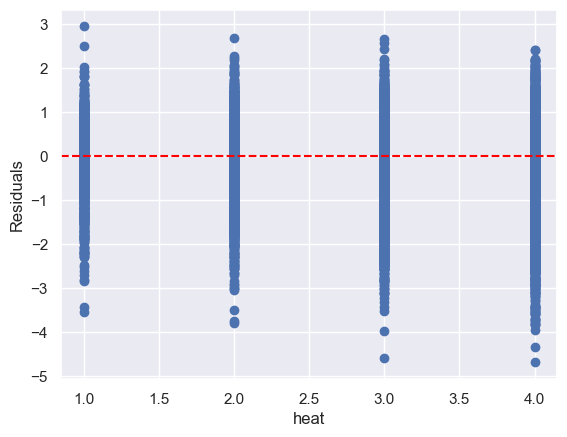

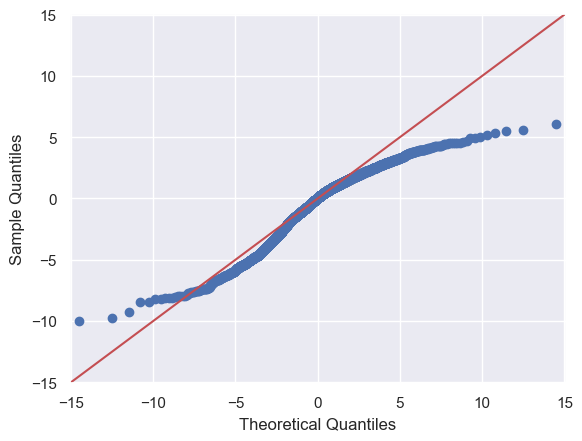

   VIF Factor     features
0    24.99730         beds
1    15.43490        baths
2     9.97257  sqft_living
3    39.12068     yr_built
4    34.42175         heat


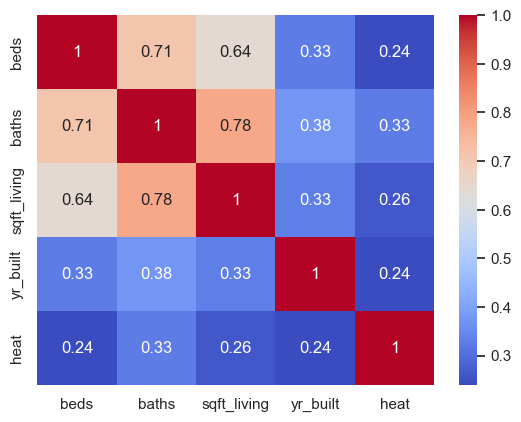

In [ ]:
run_diagnostics(sales_for_stat, result, ["beds", "baths", "sqft_living", "yr_built", "heat"])